## Final Project Submission

Please fill out:
* Student name: Jeremy Pagirsky
* Student pace: Part Time
* Scheduled project review date/time: 02/04/21 @ 2:00 PM
* Instructor name: Lindsey Berlin
* Blog post URL: https://jeremy-pagirsky.medium.com/one-way-to-do-a-descriptive-analysis-a-step-by-step-guide-9692c660e639


## Objective

Like many American cities, housing in Seattle is becoming increasingly more expensive. According to [Norada](https://www.noradarealestate.com/blog/seattle-real-estate-market/), median housing prices in the city have appreciated about 118% since 2012, from 355,000 to 773,508 dollars. This can put great pressure onto many of its working residents to afford the steeply increased cost of living.

This project attempts to illumine the factors associated with housing price increases in Seattle for those looking to purchase a new home. In particular, this project will attempt to ascertain which zip codes may play a role in housing prices.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows=200
pd.options.display.max_columns=200

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
pwd

'/Users/jerpagirsky/Desktop/Flatiron/CourseMaterials/Phase_2/Phase_2_Project'

In [3]:
cd Data

/Users/jerpagirsky/Desktop/Flatiron/CourseMaterials/Phase_2/Phase_2_Project/data


In [4]:
ls

column_names.md    kc_house_data.csv


In [5]:
df = pd.read_csv('kc_house_data.csv')
df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0          5650     1.0         NaN   0.0          3      7        1180   
1          7242     2.0         0.0   0.0          3      7        2170   
2         10000     1.0         0.0   0.0          3      6         770   
3          5000     1.0         0.0   0.0          5      7        1050   
4          8080     1.0         0.0   0.0          3      8        1680   
...         ...     ...         ...   ...        ...    ...         ...   
21592      1131     3.0         0.0   0.0          3      8        1530   
21593      5813     2.0         0.0   0.0          3      8        2310   
21594      1350     2.0         0.0   0.0          3      7        1020   
21595      2388     2.0         NaN   0.0          3      8        1600   
21596      1076     2.0         0.0   0.0          3      7        1020   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0               0.0      1955           0.0    98178  47.5112 -122.257   
1             400.0      1951        1991.0    98125  47.7210 -122.319   
2               0.0      1933           NaN    98028  47.7379 -122.233   
3             910.0      1965           0.0    98136  47.5208 -122.393   
4               0.0      1987           0.0    98074  47.6168 -122.045   
...             ...       ...           ...      ...      ...      ...   
21592           0.0      2009           0.0    98103  47.6993 -122.346   
21593           0.0      2014           0.0    98146  47.5107 -122.362   
21594           0.0      2009           0.0    98144  47.5944 -122.299   
21595           0.0      2004           0.0    98027  47.5345 -122.069   
21596           0.0      2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### Isolating Seattle Data

In [7]:
#Amount of zip codes in King County
len(df['zipcode'].unique())

70

In [8]:
seattle_zips = [98101, 98102, 98103, 98104, 98105,
                98106, 98107, 98108, 98109, 98110,
                98112, 98115, 98116, 98117, 98118,
                98119, 98121, 98122, 98125, 98126,
                98129, 98131, 98133, 98134, 98136,
                98144, 98146, 98148, 98154, 98155,
                98158, 98161, 98164, 98166, 98168,
                98170, 98174, 98177, 98178, 98181,
                98185, 98188, 98190, 98191, 98195,
                98198, 98199]

Source: [USPS](https://m.usps.com/m/ZipLookupAction?search=city)

In [9]:
#Amount of zip codes in Seattle
len(seattle_zips)

47

In [10]:
#Creating a column to code whether or not a home is in Seattle
df['in_seattle'] = np.where(df['zipcode'].isin(seattle_zips), 1, 0)

In [11]:
#Pulling data where a house's zip code is in Seattle
seattle_df = df[df['in_seattle'] == 1]
seattle_df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
7      2008000270   1/15/2015  291850.0         3       1.50         1060   
8      2414600126   4/15/2015  229500.0         3       1.00         1780   
...           ...         ...       ...       ...        ...          ...   
21591  2997800021   2/19/2015  475000.0         3       2.50         1310   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0          5650     1.0         NaN   0.0          3      7        1180   
1          7242     2.0         0.0   0.0          3      7        2170   
3          5000     1.0         0.0   0.0          5      7        1050   
7          9711     1.0         0.0   NaN          3      7        1060   
8          7470     1.0         0.0   0.0          3      7        1050   
...         ...     ...         ...   ...        ...    ...         ...   
21591      1294     2.0         0.0   0.0          3      8        1180   
21592      1131     3.0         0.0   0.0          3      8        1530   
21593      5813     2.0         0.0   0.0          3      8        2310   
21594      1350     2.0         0.0   0.0          3      7        1020   
21596      1076     2.0         0.0   0.0          3      7        1020   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0               0.0      1955           0.0    98178  47.5112 -122.257   
1             400.0      1951        1991.0    98125  47.7210 -122.319   
3             910.0      1965           0.0    98136  47.5208 -122.393   
7               0.0      1963           0.0    98198  47.4095 -122.315   
8             730.0      1960           0.0    98146  47.5123 -122.337   
...             ...       ...           ...      ...      ...      ...   
21591         130.0      2008           0.0    98116  47.5773 -122.409   
21592           0.0      2009           0.0    98103  47.6993 -122.346   
21593           0.0      2014           0.0    98146  47.5107 -122.362   
21594           0.0      2009           0.0    98144  47.5944 -122.299   
21596           0.0      2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  in_seattle  
0               1340        5650           1  
1               1690        7639           1  
3               1360        5000           1  
7               1650        9711           1  
8               1780        8113           1  
...              ...         ...         ...  
21591           1330        1265           1  
21592           1530        1509           1  
21593           1830        7200           1  
21594           1020        2007           1  
21596           1020        1357           1  

[8973 rows x 22 columns]

In [12]:
seattle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8973 entries, 0 to 21596
Data columns (total 22 columns):
id               8973 non-null int64
date             8973 non-null object
price            8973 non-null float64
bedrooms         8973 non-null int64
bathrooms        8973 non-null float64
sqft_living      8973 non-null int64
sqft_lot         8973 non-null int64
floors           8973 non-null float64
waterfront       7973 non-null float64
view             8946 non-null float64
condition        8973 non-null int64
grade            8973 non-null int64
sqft_above       8973 non-null int64
sqft_basement    8973 non-null object
yr_built         8973 non-null int64
yr_renovated     7327 non-null float64
zipcode          8973 non-null int64
lat              8973 non-null float64
long             8973 non-null float64
sqft_living15    8973 non-null int64
sqft_lot15       8973 non-null int64
in_seattle       8973 non-null int64
dtypes: float64(8), int64(12), object(2)
memory usage: 1.6+ 

In [13]:
seattle_df.drop(columns=['date', 'in_seattle'], inplace = True)

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
seattle_df

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520  221900.0         3       1.00         1180      5650   
1      6414100192  538000.0         3       2.25         2570      7242   
3      2487200875  604000.0         4       3.00         1960      5000   
7      2008000270  291850.0         3       1.50         1060      9711   
8      2414600126  229500.0         3       1.00         1780      7470   
...           ...       ...       ...        ...          ...       ...   
21591  2997800021  475000.0         3       2.50         1310      1294   
21592   263000018  360000.0         3       2.50         1530      1131   
21593  6600060120  400000.0         4       2.50         2310      5813   
21594  1523300141  402101.0         2       0.75         1020      1350   
21596  1523300157  325000.0         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_above sqft_basement  \
0         1.0         NaN   0.0          3      7        1180           0.0   
1         2.0         0.0   0.0          3      7        2170         400.0   
3         1.0         0.0   0.0          5      7        1050         910.0   
7         1.0         0.0   NaN          3      7        1060           0.0   
8         1.0         0.0   0.0          3      7        1050         730.0   
...       ...         ...   ...        ...    ...         ...           ...   
21591     2.0         0.0   0.0          3      8        1180         130.0   
21592     3.0         0.0   0.0          3      8        1530           0.0   
21593     2.0         0.0   0.0          3      8        2310           0.0   
21594     2.0         0.0   0.0          3      7        1020           0.0   
21596     2.0         0.0   0.0          3      7        1020           0.0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0          1955           0.0    98178  47.5112 -122.257           1340   
1          1951        1991.0    98125  47.7210 -122.319           1690   
3          1965           0.0    98136  47.5208 -122.393           1360   
7          1963           0.0    98198  47.4095 -122.315           1650   
8          1960           0.0    98146  47.5123 -122.337           1780   
...         ...           ...      ...      ...      ...            ...   
21591      2008           0.0    98116  47.5773 -122.409           1330   
21592      2009           0.0    98103  47.6993 -122.346           1530   
21593      2014           0.0    98146  47.5107 -122.362           1830   
21594      2009           0.0    98144  47.5944 -122.299           1020   
21596      2008           0.0    98144  47.5941 -122.299           1020   

       sqft_lot15  
0            5650  
1            7639  
3            5000  
7            9711  
8            8113  
...           ...  
21591        1265  
21592        1509  
21593        7200  
21594        2007  
21596        1357  

[8973 rows x 20 columns]

In [15]:
#assuming null values for waterfront mean apt is not on waterfront
seattle_df['waterfront'] = seattle_df['waterfront'].fillna(0)

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Initial Data Cleaning

In [16]:
#using only the recommended features from Flatiron
first_model = ['id','price','sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms',
          'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'zipcode']

In [17]:
first_model

['id',
 'price',
 'sqft_living',
 'sqft_lot',
 'bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'yr_built',
 'zipcode']

In [18]:
first_model = seattle_df[first_model]

In [19]:
first_model

id     price  sqft_living  sqft_lot  bedrooms  bathrooms  \
0      7129300520  221900.0         1180      5650         3       1.00   
1      6414100192  538000.0         2570      7242         3       2.25   
3      2487200875  604000.0         1960      5000         4       3.00   
7      2008000270  291850.0         1060      9711         3       1.50   
8      2414600126  229500.0         1780      7470         3       1.00   
...           ...       ...          ...       ...       ...        ...   
21591  2997800021  475000.0         1310      1294         3       2.50   
21592   263000018  360000.0         1530      1131         3       2.50   
21593  6600060120  400000.0         2310      5813         4       2.50   
21594  1523300141  402101.0         1020      1350         2       0.75   
21596  1523300157  325000.0         1020      1076         2       0.75   

       floors  waterfront  condition  grade  yr_built  zipcode  
0         1.0         0.0          3      7      1955    98178  
1         2.0         0.0          3      7      1951    98125  
3         1.0         0.0          5      7      1965    98136  
7         1.0         0.0          3      7      1963    98198  
8         1.0         0.0          3      7      1960    98146  
...       ...         ...        ...    ...       ...      ...  
21591     2.0         0.0          3      8      2008    98116  
21592     3.0         0.0          3      8      2009    98103  
21593     2.0         0.0          3      8      2014    98146  
21594     2.0         0.0          3      7      2009    98144  
21596     2.0         0.0          3      7      2008    98144  

[8973 rows x 12 columns]

In [20]:
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8973 entries, 0 to 21596
Data columns (total 12 columns):
id             8973 non-null int64
price          8973 non-null float64
sqft_living    8973 non-null int64
sqft_lot       8973 non-null int64
bedrooms       8973 non-null int64
bathrooms      8973 non-null float64
floors         8973 non-null float64
waterfront     8973 non-null float64
condition      8973 non-null int64
grade          8973 non-null int64
yr_built       8973 non-null int64
zipcode        8973 non-null int64
dtypes: float64(4), int64(8)
memory usage: 911.3 KB


In [21]:
#checking for duplicates
first_model[first_model['id'].duplicated() == True]

id      price  sqft_living  sqft_lot  bedrooms  bathrooms  \
94     6021501535   700000.0         1580      5000         3       1.50   
325    7520000520   240500.0         1240     12092         2       1.00   
346    3969300030   239900.0         1000      7134         4       1.00   
372    2231500030   530000.0         2180     10754         4       2.25   
718    8820903380   730000.0         2660     13579         6       2.25   
824     726049190   431000.0         1810      7200         3       1.00   
1085   9834200885   550000.0         2080      4080         4       2.50   
1201   1231000510   510000.0         1490      3800         3       1.75   
1233   6117501820   435000.0          790     11234         2       1.00   
1449   2228900270   302000.0         1010      6000         2       1.00   
1575   7888000390   235000.0         1060      7473         3       1.00   
2037   3395040550   320000.0         1530      2890         3       2.50   
2501   1781500435   575000.0         1580      7344         3       1.75   
2530   1232000810   537000.0         1400      4800         3       2.50   
2975   9136103130   685000.0         1090      4013         2       1.50   
3032   5083000375   235000.0         1310      9529         3       1.00   
3296   7409700215   921500.0         1900      5000         3       1.50   
3537   1823049202   326000.0         1930      8400         6       1.50   
3620   2767602141   650000.0         1380      4290         3       1.50   
3753   1254200015   625000.0         2260      5500         3       2.50   
3782    723049156   284700.0         1700      8645         3       1.00   
3790   4435000705   255500.0         1350      8700         3       1.00   
3875   4364700600   390000.0         1010      7920         3       1.00   
5240   3303000130   520000.0         1770      7667         3       2.25   
5336   6632900574   595000.0         2980     10064         5       3.00   
5588   2726049071   489950.0          820      4206         2       1.00   
5752   6381500170   365000.0          910      7617         2       1.00   
6340   9828200460   430000.0          700      4800         2       1.00   
6366   9222400605   850000.0         2980      4500         5       4.00   
6897   5249801440   570000.0         1660      7650         3       1.00   
7239   1446403850   212000.0          790      7153         2       1.00   
8268   3883800011   219900.0          860     10426         3       1.00   
8334   4154300296   545000.0          960      5030         3       1.00   
8427   1721801010   302100.0         1790      6120         3       1.00   
8524   5101405604   395000.0          900      6380         1       1.00   
8896   5282200015   840000.0         2750      3800         5       3.00   
8907   7977201065   740000.0         1380      4590         3       1.75   
9008   3739500096   430000.0         1540      6000         3       2.00   
9106   1568100300   682500.0         3500      8504         6       4.50   
9269   8129700644   780000.0         2080      2250         3       4.00   
9271   4443800385   778100.0         1480      4080         2       1.00   
9431   4302201085   546940.0         1470      7680         3       1.00   
9498   8103000110   490000.0         1480     15641         2       1.50   
9712   2568300045   649950.0         1900      8240         6       2.00   
9811   3598600049   224000.0          840      7203         1       0.75   
9866   1219000473   371000.0         1570     15330         3       1.75   
10211  3293700496   450000.0         1850      7730         4       1.75   
10247  1995200200   415000.0         1510      6083         3       1.00   
10599  2767603612   489000.0         1290      1334         2       2.25   
10958  3271300955   868000.0         2020      4350         4       2.50   
11050  6141100320   570000.0         1500      6685         2       1.00   
11276  5101402435   539000.0         1540      5338         3  

In [22]:
first_model = first_model.drop_duplicates(subset=['id'])

In [23]:
first_model

id     price  sqft_living  sqft_lot  bedrooms  bathrooms  \
0      7129300520  221900.0         1180      5650         3       1.00   
1      6414100192  538000.0         2570      7242         3       2.25   
3      2487200875  604000.0         1960      5000         4       3.00   
7      2008000270  291850.0         1060      9711         3       1.50   
8      2414600126  229500.0         1780      7470         3       1.00   
...           ...       ...          ...       ...       ...        ...   
21591  2997800021  475000.0         1310      1294         3       2.50   
21592   263000018  360000.0         1530      1131         3       2.50   
21593  6600060120  400000.0         2310      5813         4       2.50   
21594  1523300141  402101.0         1020      1350         2       0.75   
21596  1523300157  325000.0         1020      1076         2       0.75   

       floors  waterfront  condition  grade  yr_built  zipcode  
0         1.0         0.0          3      7      1955    98178  
1         2.0         0.0          3      7      1951    98125  
3         1.0         0.0          5      7      1965    98136  
7         1.0         0.0          3      7      1963    98198  
8         1.0         0.0          3      7      1960    98146  
...       ...         ...        ...    ...       ...      ...  
21591     2.0         0.0          3      8      2008    98116  
21592     3.0         0.0          3      8      2009    98103  
21593     2.0         0.0          3      8      2014    98146  
21594     2.0         0.0          3      7      2009    98144  
21596     2.0         0.0          3      7      2008    98144  

[8885 rows x 12 columns]

Visualizing prices of homes per zip code.

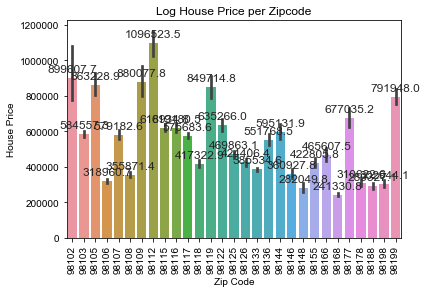

In [24]:
ax = sns.barplot('zipcode', 'price', data=first_model)
sns.set(rc={'figure.figsize':(22,15)})
plt.title('Log House Price per Zipcode')
plt.xlabel('Zip Code')
plt.ylabel('House Price')
plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Getting a closer look at the value counts for the categorical variables.

In [25]:
first_model['bedrooms'].value_counts()

3     3927
4     2104
2     2001
5      545
1      139
6      131
7       21
8        8
9        6
11       1
10       1
33       1
Name: bedrooms, dtype: int64

In [26]:
first_model = first_model[first_model['bedrooms'] < 10]

In [27]:
first_model['bedrooms'].value_counts()

3    3927
4    2104
2    2001
5     545
1     139
6     131
7      21
8       8
9       6
Name: bedrooms, dtype: int64

In [28]:
first_model['bathrooms'].value_counts()

1.00    2542
1.75    1332
2.50    1175
2.00     960
1.50     816
2.25     629
2.75     360
3.00     353
3.50     253
3.25     250
3.75      59
4.00      38
0.75      36
4.50      32
4.25      21
4.75       7
1.25       7
0.50       3
5.00       2
5.25       1
5.75       1
6.25       1
6.75       1
5.50       1
7.50       1
8.00       1
Name: bathrooms, dtype: int64

In [29]:
first_model['floors'].value_counts()

1.0    4694
2.0    2130
1.5    1391
3.0     558
2.5     102
3.5       7
Name: floors, dtype: int64

In [30]:
first_model['grade'].value_counts()

7     4233
8     2269
6     1310
9      670
10     217
5       96
11      60
12      13
4        8
13       6
Name: grade, dtype: int64

In [31]:
first_model['condition'].value_counts()

3    5687
4    2141
5     949
2      87
1      18
Name: condition, dtype: int64

In [32]:
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 12 columns):
id             8882 non-null int64
price          8882 non-null float64
sqft_living    8882 non-null int64
sqft_lot       8882 non-null int64
bedrooms       8882 non-null int64
bathrooms      8882 non-null float64
floors         8882 non-null float64
waterfront     8882 non-null float64
condition      8882 non-null int64
grade          8882 non-null int64
yr_built       8882 non-null int64
zipcode        8882 non-null int64
dtypes: float64(4), int64(8)
memory usage: 902.1 KB


In [33]:
first_model['yr_built']

0        1955
1        1951
3        1965
7        1963
8        1960
         ... 
21591    2008
21592    2009
21593    2014
21594    2009
21596    2008
Name: yr_built, Length: 8882, dtype: int64

I am converting `yr_built` into an age variable that will eventually be binned.

In [34]:
#convert yr_built into age in years (2020)
age = []
for x in first_model['yr_built']:
    age.append(2015 - x)

In [35]:
first_model['age_(yr)'] = pd.DataFrame(age, index=first_model.index)

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
first_model

id     price  sqft_living  sqft_lot  bedrooms  bathrooms  \
0      7129300520  221900.0         1180      5650         3       1.00   
1      6414100192  538000.0         2570      7242         3       2.25   
3      2487200875  604000.0         1960      5000         4       3.00   
7      2008000270  291850.0         1060      9711         3       1.50   
8      2414600126  229500.0         1780      7470         3       1.00   
...           ...       ...          ...       ...       ...        ...   
21591  2997800021  475000.0         1310      1294         3       2.50   
21592   263000018  360000.0         1530      1131         3       2.50   
21593  6600060120  400000.0         2310      5813         4       2.50   
21594  1523300141  402101.0         1020      1350         2       0.75   
21596  1523300157  325000.0         1020      1076         2       0.75   

       floors  waterfront  condition  grade  yr_built  zipcode  age_(yr)  
0         1.0         0.0          3      7      1955    98178        60  
1         2.0         0.0          3      7      1951    98125        64  
3         1.0         0.0          5      7      1965    98136        50  
7         1.0         0.0          3      7      1963    98198        52  
8         1.0         0.0          3      7      1960    98146        55  
...       ...         ...        ...    ...       ...      ...       ...  
21591     2.0         0.0          3      8      2008    98116         7  
21592     3.0         0.0          3      8      2009    98103         6  
21593     2.0         0.0          3      8      2014    98146         1  
21594     2.0         0.0          3      7      2009    98144         6  
21596     2.0         0.0          3      7      2008    98144         7  

[8882 rows x 13 columns]

(array([1632.,  444.,  562., 2012., 1730., 1450., 1052.]),
 array([  0.        ,  16.42857143,  32.85714286,  49.28571429,
         65.71428571,  82.14285714,  98.57142857, 115.        ]),
 <a list of 7 Patch objects>)

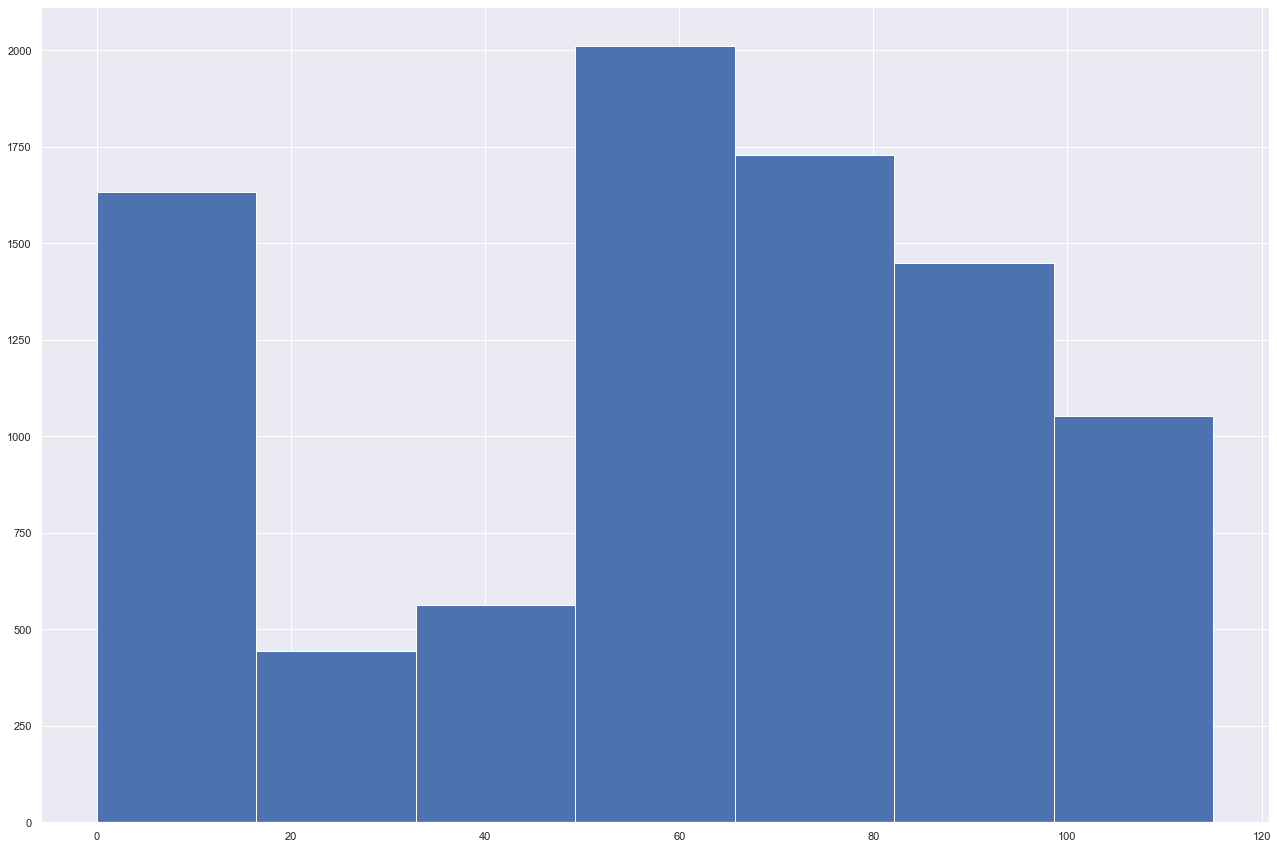

In [37]:
plt.hist('age_(yr)', data=first_model, bins=7)

In [38]:
sorted(first_model['age_(yr)'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115]

In [39]:
#binning ages 
first_model['age_bins'] = pd.cut(x=first_model['age_(yr)'], bins=[0, 20, 40, 60, 80, 100, 120])

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
first_model.head(200)

id      price  sqft_living  sqft_lot  bedrooms  bathrooms  \
0    7129300520   221900.0         1180      5650         3       1.00   
1    6414100192   538000.0         2570      7242         3       2.25   
3    2487200875   604000.0         1960      5000         4       3.00   
7    2008000270   291850.0         1060      9711         3       1.50   
8    2414600126   229500.0         1780      7470         3       1.00   
11   9212900260   468000.0         1160      6000         2       1.00   
14   1175000570   530000.0         1810      4850         5       2.00   
15   9297300055   650000.0         2950      5000         4       3.00   
17   6865200140   485000.0         1600      4300         4       1.00   
20   6300500875   385000.0         1620      4980         4       1.75   
26   1794500383   937000.0         2450      2691         3       1.75   
27   3303700376   667000.0         1400      1581         3       1.00   
28   5101402488   438000.0         1520      6380         3       1.75   
31   2426039314   280000.0         1190      1265         2       1.50   
32    461000390   687500.0         2330      5000         4       1.75   
33   7589200193   535000.0         1090      3000         3       1.00   
35   9547205180   696000.0         2300      3060         3       2.50   
37   2768000400   640000.0         2360      6000         4       2.00   
41   7766200013   775000.0         4220     24186         4       2.25   
43   9270200160   685000.0         1570      2280         3       1.00   
48   9215400105   450000.0         1250      5963         3       1.75   
50   5245600105   228000.0         1190      9199         3       1.00   
52   7518505990   600000.0         1410      4080         3       1.75   
53   3626039271   585000.0         1980      8550         2       1.75   
54   4217401195   920000.0         2730      6000         5       2.25   
55   9822700295   885000.0         2830      5000         4       2.50   
60   1516000055   650000.0         2150     21235         3       2.25   
61   9558200045   289000.0         1260      8400         3       1.75   
62   5072410070   505000.0         2519      8690         3       1.75   
63   9528102996   549000.0         1540      1044         3       1.75   
64   1189001180   425000.0         1660      6000         3       2.25   
65   3253500160   317625.0         2770      3809         3       2.75   
72   8820901275   571000.0         2750      7807         4       2.00   
77   2391600320   480000.0         1040      5060         3       1.00   
78   6300000287   410000.0         1410      5060         3       1.00   
82   9418400240   355000.0         2020      6720         2       1.00   
84   1133000671   315000.0          960      6634         3       1.00   
85   4232902595   940000.0         2140      3600         3       1.50   
89   3869900162   335000.0         1030      1066         2       1.75   
91   5036300431  1100000.0         3520      6353         5       2.75   
93   6021501535   430000.0         1580      5000         3       1.50   
100  1952200240   850830.0         2070     13241         3       2.50   
101  5200100125   555000.0         1980      3478         3       2.00   
106   546000875   460000.0         1670      4005         3       1.00   
107  3530510041   188500.0         1240      2493         2       1.75   
111  3362400511   570000.0         1260      3328         3       1.75   
113  6126500060   329950.0         2080      5969         3       1.75   
115  3626039325   740500.0         4380      6350         3       3.50   
116  3362400431   518500.0         1590      1102         3       3.50   
117  4060000240   205425.0          880      6780         2       1.00   
118  3454800060   171800.0         1570      9600         4       2.00   
119  1695900060   535000.0         1610      2982         4       1.00   
120  7278700070   660000.0         2400      6474         3       2.50   
122  3626039187  

In [41]:
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 14 columns):
id             8882 non-null int64
price          8882 non-null float64
sqft_living    8882 non-null int64
sqft_lot       8882 non-null int64
bedrooms       8882 non-null int64
bathrooms      8882 non-null float64
floors         8882 non-null float64
waterfront     8882 non-null float64
condition      8882 non-null int64
grade          8882 non-null int64
yr_built       8882 non-null int64
zipcode        8882 non-null int64
age_(yr)       8882 non-null int64
age_bins       8855 non-null category
dtypes: category(1), float64(4), int64(9)
memory usage: 980.4 KB


In [42]:
first_model.drop(columns=['yr_built', 'age_(yr)'], inplace=True)

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
first_model.head()

id     price  sqft_living  sqft_lot  bedrooms  bathrooms  floors  \
0  7129300520  221900.0         1180      5650         3       1.00     1.0   
1  6414100192  538000.0         2570      7242         3       2.25     2.0   
3  2487200875  604000.0         1960      5000         4       3.00     1.0   
7  2008000270  291850.0         1060      9711         3       1.50     1.0   
8  2414600126  229500.0         1780      7470         3       1.00     1.0   

   waterfront  condition  grade  zipcode  age_bins  
0         0.0          3      7    98178  (40, 60]  
1         0.0          3      7    98125  (60, 80]  
3         0.0          5      7    98136  (40, 60]  
7         0.0          3      7    98198  (40, 60]  
8         0.0          3      7    98146  (40, 60]

In [44]:
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 12 columns):
id             8882 non-null int64
price          8882 non-null float64
sqft_living    8882 non-null int64
sqft_lot       8882 non-null int64
bedrooms       8882 non-null int64
bathrooms      8882 non-null float64
floors         8882 non-null float64
waterfront     8882 non-null float64
condition      8882 non-null int64
grade          8882 non-null int64
zipcode        8882 non-null int64
age_bins       8855 non-null category
dtypes: category(1), float64(4), int64(7)
memory usage: 841.6 KB


In [45]:
X_cols = [c for c in first_model.columns.to_list() if c not in ['id','price']]

In [46]:
X_cols

['sqft_living',
 'sqft_lot',
 'bedrooms',
 'bathrooms',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'zipcode',
 'age_bins']

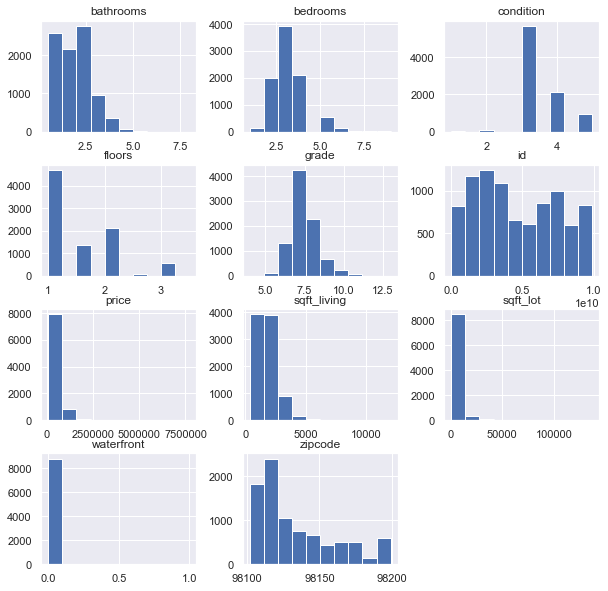

In [47]:
#checking skewness of continuous data
first_model.hist(figsize  = [10, 10]);

In [48]:
first_model.sort_values(by='sqft_living', ascending=False)

id      price  sqft_living  sqft_lot  bedrooms  bathrooms  \
7245   6762700020  7700000.0        12050     27600         6       8.00   
14542  2303900035  2890000.0         8670     64033         5       6.25   
13398  2426039123  2420000.0         7880     24250         5       4.75   
18462  1346300150  3300000.0         7710     11750         8       4.00   
4020   9175600025   800000.0         7480     41664         7       6.75   
...           ...        ...          ...       ...       ...        ...   
14452  7549801385   280000.0          420      6720         1       0.75   
8614   6303400395   325000.0          410      8636         1       0.75   
21316  9266700190   245000.0          390      2000         1       1.00   
860    1723049033   245000.0          380     15000         1       0.75   
15367  2856101479   276000.0          370      1801         1       0.75   

       floors  waterfront  condition  grade  zipcode    age_bins  
7245      2.5         0.0          4     13    98102  (100, 120]  
14542     2.0         0.0          3     13    98177    (40, 60]  
13398     2.0         0.0          3     13    98177     (0, 20]  
18462     3.5         0.0          5     12    98112  (100, 120]  
4020      2.0         0.0          3     11    98166    (60, 80]  
...       ...         ...        ...    ...      ...         ...  
14452     1.0         0.0          3      5    98108   (80, 100]  
8614      1.0         0.0          2      4    98146    (60, 80]  
21316     1.0         0.0          4      6    98103   (80, 100]  
860       1.0         0.0          3      5    98168    (40, 60]  
15367     1.0         0.0          5      5    98117   (80, 100]  

[8882 rows x 12 columns]

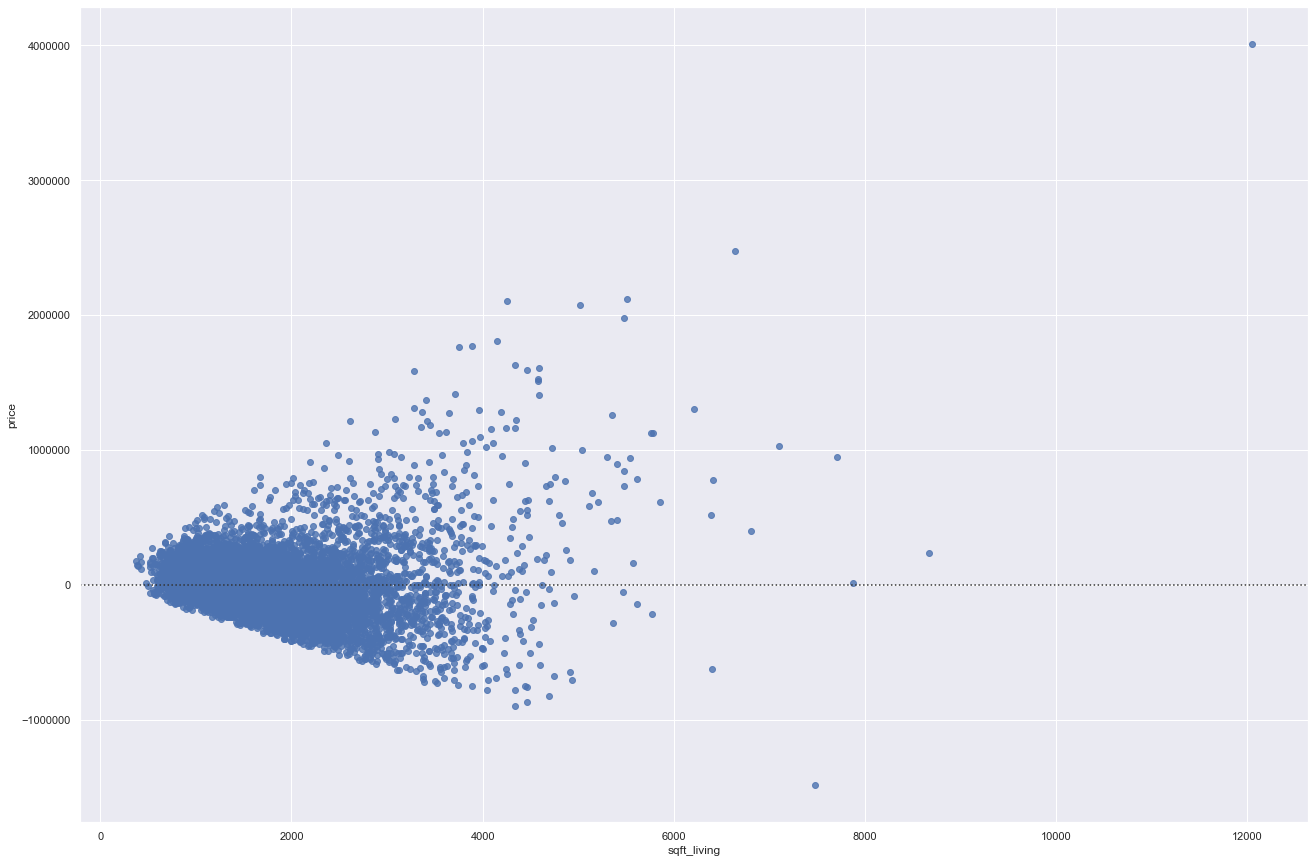

In [49]:
sns.residplot('sqft_living', 'price', data=first_model)

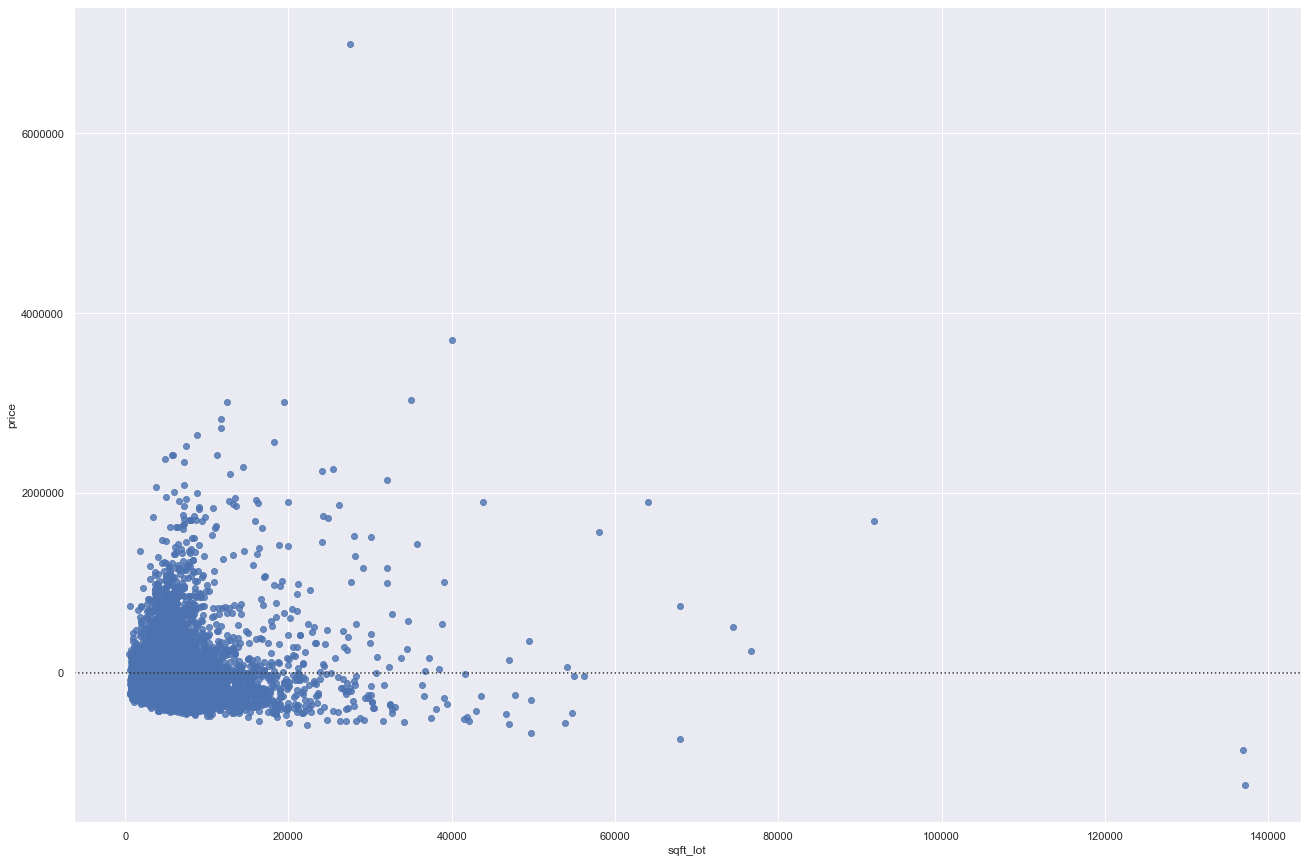

In [50]:
sns.residplot('sqft_lot', 'price', data=first_model)

The two cells below are helpful for gauging multicollinearity between features.

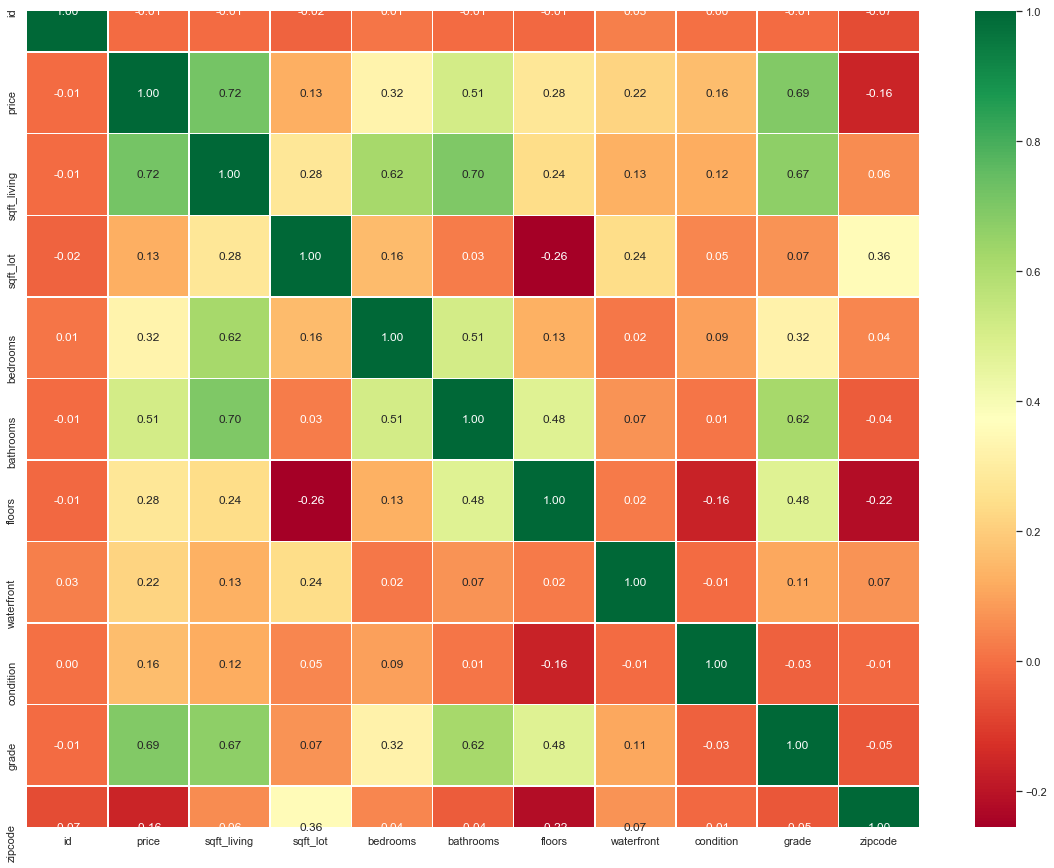

In [51]:
#correlations for all potential predictors
#the warmer colors are misleading (the darkest reds do not show very high negative correlations)
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(first_model.corr(),annot=True, fmt=".2f", linewidths=.5, ax=ax,cmap='RdYlGn')
plt.show()

In [52]:
#multicollinearity check
pd.DataFrame(first_model.corr().abs().stack().sort_values(0, ascending=False)).head(50)

0
zipcode     zipcode      1.000000
grade       grade        1.000000
price       price        1.000000
sqft_living sqft_living  1.000000
sqft_lot    sqft_lot     1.000000
bedrooms    bedrooms     1.000000
floors      floors       1.000000
waterfront  waterfront   1.000000
condition   condition    1.000000
bathrooms   bathrooms    1.000000
id          id           1.000000
sqft_living price        0.720050
price       sqft_living  0.720050
bathrooms   sqft_living  0.696151
sqft_living bathrooms    0.696151
grade       price        0.691384
price       grade        0.691384
sqft_living grade        0.667350
grade       sqft_living  0.667350
bedrooms    sqft_living  0.618573
sqft_living bedrooms     0.618573
grade       bathrooms    0.617910
bathrooms   grade        0.617910
            price        0.511337
price       bathrooms    0.511337
bedrooms    bathrooms    0.510607
bathrooms   bedrooms     0.510607
            floors       0.478696
floors      bathrooms    0.478696
grade       floors       0.477710
floors      grade        0.477710
zipcode     sqft_lot     0.355944
sqft_lot    zipcode      0.355944
price       bedrooms     0.324678
bedrooms    price        0.324678
grade       bedrooms     0.320439
bedrooms    grade        0.320439
sqft_lot    sqft_living  0.278159
sqft_living sqft_lot     0.278159
floors      price        0.276289
price       floors       0.276289
sqft_lot    floors       0.255490
floors      sqft_lot     0.255490
sqft_lot    waterfront   0.243632
waterfront  sqft_lot     0.243632
floors      sqft_living  0.240970
sqft_living floors       0.240970
waterfront  price        0.218795
price       waterfront   0.218795
floors      zipcode      0.216489

In [53]:
first_model[X_cols]

sqft_living  sqft_lot  bedrooms  bathrooms  floors  waterfront  \
0             1180      5650         3       1.00     1.0         0.0   
1             2570      7242         3       2.25     2.0         0.0   
3             1960      5000         4       3.00     1.0         0.0   
7             1060      9711         3       1.50     1.0         0.0   
8             1780      7470         3       1.00     1.0         0.0   
...            ...       ...       ...        ...     ...         ...   
21591         1310      1294         3       2.50     2.0         0.0   
21592         1530      1131         3       2.50     3.0         0.0   
21593         2310      5813         4       2.50     2.0         0.0   
21594         1020      1350         2       0.75     2.0         0.0   
21596         1020      1076         2       0.75     2.0         0.0   

       condition  grade  zipcode  age_bins  
0              3      7    98178  (40, 60]  
1              3      7    98125  (60, 80]  
3              5      7    98136  (40, 60]  
7              3      7    98198  (40, 60]  
8              3      7    98146  (40, 60]  
...          ...    ...      ...       ...  
21591          3      8    98116   (0, 20]  
21592          3      8    98103   (0, 20]  
21593          3      8    98146   (0, 20]  
21594          3      7    98144   (0, 20]  
21596          3      7    98144   (0, 20]  

[8882 rows x 10 columns]

`bathrooms` is highly correlated with `sqft_living`. I'll keep `sqft_living` because it is so strongly correlated with the outcome variable, `price`. However, I want to see what the first model looks like, even with multicollinearity, to gauge a baseline.

In [54]:
#set desired categorical variables as categories for one hot encoding
first_model['waterfront'] = first_model['waterfront'].astype('category')
first_model['bedrooms'] = first_model['bedrooms'].astype('category')
first_model['bathrooms'] = first_model['bathrooms'].astype('category')
first_model['floors'] = first_model['floors'].astype('category')
first_model['zipcode'] = first_model['zipcode'].astype('category')
first_model['age_bins'] = first_model['age_bins'].astype('category')

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is tr

In [55]:
#dummy variables
water_dum_df = pd.get_dummies(first_model['waterfront'], prefix='wtr', drop_first=True)
bed_dum_df = pd.get_dummies(first_model['bedrooms'], prefix='bed', drop_first=True)
bath_dum_df = pd.get_dummies(first_model['bathrooms'], prefix='bath', drop_first=True)
flr_dum_df = pd.get_dummies(first_model['floors'], prefix='flr', drop_first=True)
zip_dum_df = pd.get_dummies(first_model['zipcode'], prefix='zip', drop_first=True)
age_dum_df = pd.get_dummies(first_model['age_bins'], prefix='age', drop_first=True)

In [56]:
zip_dum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 28 columns):
zip_98103    8882 non-null uint8
zip_98105    8882 non-null uint8
zip_98106    8882 non-null uint8
zip_98107    8882 non-null uint8
zip_98108    8882 non-null uint8
zip_98109    8882 non-null uint8
zip_98112    8882 non-null uint8
zip_98115    8882 non-null uint8
zip_98116    8882 non-null uint8
zip_98117    8882 non-null uint8
zip_98118    8882 non-null uint8
zip_98119    8882 non-null uint8
zip_98122    8882 non-null uint8
zip_98125    8882 non-null uint8
zip_98126    8882 non-null uint8
zip_98133    8882 non-null uint8
zip_98136    8882 non-null uint8
zip_98144    8882 non-null uint8
zip_98146    8882 non-null uint8
zip_98148    8882 non-null uint8
zip_98155    8882 non-null uint8
zip_98166    8882 non-null uint8
zip_98168    8882 non-null uint8
zip_98177    8882 non-null uint8
zip_98178    8882 non-null uint8
zip_98188    8882 non-null uint8
zip_98198    8882 non-null uint8
z

## First Model (Baseline)

In [57]:
first_model = pd.concat([first_model, water_dum_df, bed_dum_df, bath_dum_df, flr_dum_df, zip_dum_df, age_dum_df], axis=1)

In [58]:
#categorized 
first_model.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 84 columns):
id                8882 non-null int64
price             8882 non-null float64
sqft_living       8882 non-null int64
sqft_lot          8882 non-null int64
bedrooms          8882 non-null category
bathrooms         8882 non-null category
floors            8882 non-null category
waterfront        8882 non-null category
condition         8882 non-null int64
grade             8882 non-null int64
zipcode           8882 non-null category
age_bins          8855 non-null category
wtr_1.0           8882 non-null uint8
bed_2             8882 non-null uint8
bed_3             8882 non-null uint8
bed_4             8882 non-null uint8
bed_5             8882 non-null uint8
bed_6             8882 non-null uint8
bed_7             8882 non-null uint8
bed_8             8882 non-null uint8
bed_9             8882 non-null uint8
bath_0.75         8882 non-null uint8
bath_1.0          8882 non-null uint

In [59]:
first_model = first_model.drop(columns=['condition', 'grade', 'waterfront', 'bedrooms', 'bathrooms', 'floors', 'zipcode', 'age_bins'])

In [60]:
first_model

id     price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
0      7129300520  221900.0         1180      5650        0      0      1   
1      6414100192  538000.0         2570      7242        0      0      1   
3      2487200875  604000.0         1960      5000        0      0      0   
7      2008000270  291850.0         1060      9711        0      0      1   
8      2414600126  229500.0         1780      7470        0      0      1   
...           ...       ...          ...       ...      ...    ...    ...   
21591  2997800021  475000.0         1310      1294        0      0      1   
21592   263000018  360000.0         1530      1131        0      0      1   
21593  6600060120  400000.0         2310      5813        0      0      0   
21594  1523300141  402101.0         1020      1350        0      1      0   
21596  1523300157  325000.0         1020      1076        0      1      0   

       bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  bath_0.75  bath_1.0  \
0          0      0      0      0      0      0          0         1   
1          0      0      0      0      0      0          0         0   
3          1      0      0      0      0      0          0         0   
7          0      0      0      0      0      0          0         0   
8          0      0      0      0      0      0          0         1   
...      ...    ...    ...    ...    ...    ...        ...       ...   
21591      0      0      0      0      0      0          0         0   
21592      0      0      0      0      0      0          0         0   
21593      1      0      0      0      0      0          0         0   
21594      0      0      0      0      0      0          1         0   
21596      0      0      0      0      0      0          1         0   

       bath_1.25  bath_1.5  bath_1.75  bath_2.0  bath_2.25  bath_2.5  \
0              0         0          0         0          0         0   
1              0         0          0         0          1         0   
3              0         0          0         0          0         0   
7              0         1          0         0          0         0   
8              0         0          0         0          0         0   
...          ...       ...        ...       ...        ...       ...   
21591          0         0          0         0          0         1   
21592          0         0          0         0          0         1   
21593          0         0          0         0          0         1   
21594          0         0          0         0          0         0   
21596          0         0          0         0          0         0   

       bath_2.75  bath_3.0  bath_3.25  bath_3.5  bath_3.75  bath_4.0  \
0              0         0          0         0          0         0   
1              0         0          0         0          0         0   
3              0         1          0         0          0         0   
7              0         0          0         0          0         0   
8              0         0          0         0          0         0   
...          ...       ...        ...       ...        ...       ...   
21591          0         0          0         0          0         0   
21592          0         0          0         0          0         0   
21593          0         0          0         0          0         0   
21594          0         0          0         0          0         0   
21596          0         0          0         0          0         0   

       bath_4.25  bath_4.5  bath_4.75  bath_5.0  bath_5.25  bath_5.5  \
0              0         0          0         0          0         0   
1              0         0          0         0          0         0   
3              0         0          0         0          0         0   
7              0         0          0         0          0         0   
8              0         0          0         0          0         0   
...          ...       ...        ...       ...        ...     

In [61]:
first_model.describe()

id         price   sqft_living       sqft_lot      wtr_1.0  \
count  8.882000e+03  8.882000e+03   8882.000000    8882.000000  8882.000000   
mean   4.605114e+09  5.357668e+05   1797.751520    6453.661675     0.007431   
std    2.843545e+09  3.416391e+05    799.502885    5445.870438     0.085886   
min    1.200019e+06  7.800000e+04    370.000000     520.000000     0.000000   
25%    2.172000e+09  3.375000e+05   1240.000000    3881.750000     0.000000   
50%    4.023204e+09  4.530000e+05   1640.000000    5559.500000     0.000000   
75%    7.234601e+09  6.300000e+05   2190.000000    7807.750000     0.000000   
max    9.900000e+09  7.700000e+06  12050.000000  137214.000000     1.000000   

             bed_2        bed_3        bed_4        bed_5        bed_6  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.225287     0.442130     0.236884     0.061360     0.014749   
std       0.417795     0.496668     0.425194     0.240003     0.120553   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             bed_7        bed_8        bed_9    bath_0.75     bath_1.0  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.002364     0.000901     0.000676     0.004053     0.286197   
std       0.048570     0.030000     0.025984     0.063539     0.452008   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         bath_1.25     bath_1.5    bath_1.75     bath_2.0    bath_2.25  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.000788     0.091871     0.149966     0.108084     0.070817   
std       0.028064     0.288860     0.357058     0.310504     0.256534   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          bath_2.5    bath_2.75     bath_3.0    bath_3.25     bath_3.5  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.132290     0.040531     0.039743     0.028147     0.028485   
std       0.338825     0.197213     0.195366     0.165401     0.166362   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         bath_3.75     bath_4.0    bath_4.25     bath_4.5    bath_4.75  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.006643     0.004278     0.002364     0.003603     0.000788   
std       0.081236     0.065272     0.048570     0.059918     0.028064   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000 

Still many outliers, but only doing baseline for now. Will address them later.

In [62]:
scaler = StandardScaler()

In [63]:
X_cols = [c for c in first_model.columns.to_list() if c not in ['price', 'id']]

In [64]:
X_cols

['sqft_living',
 'sqft_lot',
 'wtr_1.0',
 'bed_2',
 'bed_3',
 'bed_4',
 'bed_5',
 'bed_6',
 'bed_7',
 'bed_8',
 'bed_9',
 'bath_0.75',
 'bath_1.0',
 'bath_1.25',
 'bath_1.5',
 'bath_1.75',
 'bath_2.0',
 'bath_2.25',
 'bath_2.5',
 'bath_2.75',
 'bath_3.0',
 'bath_3.25',
 'bath_3.5',
 'bath_3.75',
 'bath_4.0',
 'bath_4.25',
 'bath_4.5',
 'bath_4.75',
 'bath_5.0',
 'bath_5.25',
 'bath_5.5',
 'bath_5.75',
 'bath_6.25',
 'bath_6.75',
 'bath_7.5',
 'bath_8.0',
 'flr_1.5',
 'flr_2.0',
 'flr_2.5',
 'flr_3.0',
 'flr_3.5',
 'zip_98103',
 'zip_98105',
 'zip_98106',
 'zip_98107',
 'zip_98108',
 'zip_98109',
 'zip_98112',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98136',
 'zip_98144',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98199',
 'age_(20, 40]',
 'age_(40, 60]',
 'age_(60, 80]',
 'age_(80, 100]',
 'age_(100, 120]']

In [65]:
X = first_model[X_cols]
y = first_model['price']

In [66]:
#first statsmodel lin reg
model = sm.OLS(y, sm.add_constant(X))

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [67]:
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     409.9
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:37:49   Log-Likelihood:            -1.1915e+05
No. Observations:                8882   AIC:                         2.384e+05
Df Residuals:                    8807   BIC:                         2.390e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.078e+05   9.63e+04      2.157      0.031     1.9e+04    3.97e+05
sqft_living      258.9733      3.894     66.499      0.000     251.339     266.607
sqft_lot           4.2447      0.420     10.112      0.000       3.422       5.068
wtr_1.0         5.477e+05   2.13e+04     25.757      0.000    5.06e+05    5.89e+05
bed_2          -8545.8674   1.46e+04     -0.584      0.559   -3.72e+04    2.01e+04
bed_3          -2.719e+04   1.48e+04     -1.835      0.067   -5.62e+04    1856.510
bed_4          -4.944e+04   1.55e+04     -3.193      0.001   -7.98e+04   -1.91e+04
bed_5          -1.145e+05   1.69e+04     -6.763      0.000   -1.48e+05   -8.13e+04
bed_6          -1.734e+05   2.16e+04     -8.035      0.000   -2.16e+05   -1.31e+05
bed_7          -2.577e+05   4.11e+04     -6.270      0.000   -3.38e+05   -1.77e+05
bed_8            -2.6e+05   6.29e+04     -4.137      0.000   -3.83e+05   -1.37e+05
bed_9          -4.551e+05   7.64e+04     -5.957      0.000   -6.05e+05   -3.05e+05
bath_0.75       3.728e+04   9.79e+04      0.381      0.703   -1.55e+05    2.29e+05
bath_1.0        4.545e+04   9.42e+04      0.482      0.630   -1.39e+05     2.3e+05
bath_1.25       7.474e+04   1.13e+05      0.664      0.507   -1.46e+05    2.95e+05
bath_1.5        2.179e+04   9.44e+04      0.231      0.818   -1.63e+05    2.07e+05
bath_1.75       2484.7377   9.44e+04      0.026      0.979   -1.83e+05    1.88e+05
bath_2.0       -2554.9076   9.44e+04     -0.027      0.978   -1.88e+05    1.83e+05
bath_2.25       2.793e+04   9.46e+04      0.295      0.768   -1.58e+05    2.13e+05
bath_2.5        2.096e+04   9.46e+04      0.222      0.825   -1.64e+05    2.06e+05
bath_2.75       4215.0019   9.48e+04      0.044      0.965   -1.82e+05     1.9e+05
bath_3.0        4.328e+04   9.49e+04      0.456      0.648   -1.43e+05    2.29e+05
bath_3.25       1.327e+05   9.51e+04      1.394      0.163   -5.38e+04    3.19e+05
bath_3.5        7.174e+04   9.52e+04      0.753      0.451   -1.15e+05    2.58e+05
bath_3.75       1.658e+05   9.71e+04      1.709      0.088   -2.44e+04    3.56e+05
bath_4.0        1.863e+05   9.85e+04      1.892      0.058   -6685.546    3.79e+05
bath_4.25       4.532e+05   1.01e+05      4.469      0.000    2.54e+05    6.52e+05
bath_4.5        1.584e+05   9.95e+04      1.592      0.111   -3.66e+04    3.53e+05
bath_4.75       8.647e+05   1.14e+05      7.596      0.000    6.42e+05    1.09e+06
bath_5.0        5.067e+05   1.53e+05      3.311      0.001    2.07e+05    8.07e+05
bath_5.25      -1.478e+05   1.89e+05     -0.782      0.434   -5.18e+05    2.23e+05
bath_5.5         2.27e+06    1.9e+05     11.918      0.000     1.9e+06    2.64e+06
bath_5.75      -1.758e+05   1.92e+05     -0.915      0.360   -5.52e+05    2.01e+05
bath_6.25       4.362e+05   1.91e+05      2.285      0.022    6.21e+04     8.1e+05
bath_6.75   

An extraordinarily high JB score. I intentionally hadn't transformed my continuous predictors for the BL model, so this is expected.

In [68]:
lr = LinearRegression()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
len(X_test) + len(X_train) == len(X)

True

In [71]:
X_train.shape

(6661, 74)

In [72]:
X_test.shape

(2221, 74)

In [73]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [75]:
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [76]:
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error V1: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Root Mean Squared Error V2: {mean_squared_error(y_test, y_test_pred, squared=False)}")

Training Scores:
R2: 0.7836113678306824
Mean Absolute Error: 103529.74575826593
---
Testing Scores:
R2: -1.5557889301953085e+20
Mean Absolute Error: 120441023426055.52
Root Mean Squared Error V1: 4397360691673776.0
Root Mean Squared Error V2: 4397360691673776.0


Overfit and both MAE and RMSE look quite high. Also note the negative R2 value. Let's look at what we can do to fix this.

In [77]:
X = first_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = first_model[X_cols].columns
vif

VIF        features
0   19.684922     sqft_living
1    4.213841        sqft_lot
2    1.126789         wtr_1.0
3   16.023123           bed_2
4   32.300471           bed_3
5   18.914855           bed_4
6    5.864293           bed_5
7    2.296103           bed_6
8    1.338628           bed_7
9    1.193312           bed_8
10   1.321857           bed_9
11   1.529048       bath_0.75
12  48.413602        bath_1.0
13   1.126581       bath_1.25
14  16.702203        bath_1.5
15  26.728872       bath_1.75
16  19.760889        bath_2.0
17  13.371380       bath_2.25
18  24.251935        bath_2.5
19   8.250423       bath_2.75
20   8.071674        bath_3.0
21   6.259788       bath_3.25
22   6.377171        bath_3.5
23   2.295380       bath_3.75
24   1.912724        bath_4.0
25   1.527391       bath_4.25
26   1.854249        bath_4.5
27   1.218892       bath_4.75
28   1.136168        bath_5.0
29   1.036363       bath_5.25
30   1.052904        bath_5.5
31   1.082383       bath_5.75
32   1.061812       bath_6.25
33   1.100183       bath_6.75
34   1.240733        bath_7.5
35   1.081994        bath_8.0
36   1.762383         flr_1.5
37   3.209836         flr_2.0
38   1.206633         flr_2.5
39   2.187391         flr_3.0
40   1.040962         flr_3.5
41   6.807139       zip_98103
42   3.212675       zip_98105
43   4.264018       zip_98106
44   3.561904       zip_98107
45   2.811327       zip_98108
46   2.047988       zip_98109
47   3.587385       zip_98112
48   6.644182       zip_98115
49   4.184469       zip_98116
50   6.334284       zip_98117
51   5.852377       zip_98118
52   2.767738       zip_98119
53   3.766111       zip_98122
54   5.043396       zip_98125
55   4.437765       zip_98126
56   5.841524       zip_98133
57   3.561275       zip_98136
58   4.276326       zip_98144
59   3.860534       zip_98146
60   1.578167       zip_98148
61   5.544637       zip_98155
62   3.631308       zip_98166
63   3.758427       zip_98168
64   3.636220       zip_98177
65   3.619343       zip_98178
66   2.409504       zip_98188
67   3.885194       zip_98198
68   4.106532       zip_98199
69   1.800209    age_(20, 40]
70   4.005341    age_(40, 60]
71   6.355358    age_(60, 80]
72   4.053591   age_(80, 100]
73   2.732813  age_(100, 120]

In [78]:
X = first_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = first_model[X_cols].columns
vif

VIF        features
0   19.684922     sqft_living
1    4.213841        sqft_lot
2    1.126789         wtr_1.0
3   16.023123           bed_2
4   32.300471           bed_3
5   18.914855           bed_4
6    5.864293           bed_5
7    2.296103           bed_6
8    1.338628           bed_7
9    1.193312           bed_8
10   1.321857           bed_9
11   1.529048       bath_0.75
12  48.413602        bath_1.0
13   1.126581       bath_1.25
14  16.702203        bath_1.5
15  26.728872       bath_1.75
16  19.760889        bath_2.0
17  13.371380       bath_2.25
18  24.251935        bath_2.5
19   8.250423       bath_2.75
20   8.071674        bath_3.0
21   6.259788       bath_3.25
22   6.377171        bath_3.5
23   2.295380       bath_3.75
24   1.912724        bath_4.0
25   1.527391       bath_4.25
26   1.854249        bath_4.5
27   1.218892       bath_4.75
28   1.136168        bath_5.0
29   1.036363       bath_5.25
30   1.052904        bath_5.5
31   1.082383       bath_5.75
32   1.061812       bath_6.25
33   1.100183       bath_6.75
34   1.240733        bath_7.5
35   1.081994        bath_8.0
36   1.762383         flr_1.5
37   3.209836         flr_2.0
38   1.206633         flr_2.5
39   2.187391         flr_3.0
40   1.040962         flr_3.5
41   6.807139       zip_98103
42   3.212675       zip_98105
43   4.264018       zip_98106
44   3.561904       zip_98107
45   2.811327       zip_98108
46   2.047988       zip_98109
47   3.587385       zip_98112
48   6.644182       zip_98115
49   4.184469       zip_98116
50   6.334284       zip_98117
51   5.852377       zip_98118
52   2.767738       zip_98119
53   3.766111       zip_98122
54   5.043396       zip_98125
55   4.437765       zip_98126
56   5.841524       zip_98133
57   3.561275       zip_98136
58   4.276326       zip_98144
59   3.860534       zip_98146
60   1.578167       zip_98148
61   5.544637       zip_98155
62   3.631308       zip_98166
63   3.758427       zip_98168
64   3.636220       zip_98177
65   3.619343       zip_98178
66   2.409504       zip_98188
67   3.885194       zip_98198
68   4.106532       zip_98199
69   1.800209    age_(20, 40]
70   4.005341    age_(40, 60]
71   6.355358    age_(60, 80]
72   4.053591   age_(80, 100]
73   2.732813  age_(100, 120]

Multicollinearity is high for `age` between 60-80, most `bathrooms` variables, and `bedrooms` fewer than 6.

In [79]:
pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')[0].sort_values()

bath_6.25        -1.936204e+17
bath_7.5         -7.387908e+16
zip_98198        -7.965738e+04
zip_98155        -7.649896e+04
zip_98178        -7.629499e+04
zip_98168        -7.582430e+04
zip_98118        -7.434877e+04
zip_98133        -7.404755e+04
zip_98106        -6.666740e+04
zip_98146        -6.659284e+04
zip_98166        -6.545965e+04
zip_98125        -5.936773e+04
zip_98126        -5.603607e+04
zip_98188        -5.495348e+04
zip_98108        -5.399319e+04
zip_98115        -4.077409e+04
zip_98177        -3.993567e+04
zip_98117        -3.814964e+04
zip_98144        -3.726853e+04
zip_98136        -3.638907e+04
zip_98103        -3.564707e+04
zip_98148        -3.536306e+04
zip_98116        -3.157134e+04
bed_5            -2.569950e+04
zip_98122        -2.112750e+04
bed_6            -2.050730e+04
zip_98107        -1.875730e+04
bed_4            -1.793736e+04
bed_7            -1.610410e+04
zip_98199        -1.397697e+04
bath_6.75        -1.060221e+04
bed_3            -1.025168e+04
bed_9   

In [80]:
cv_5_results  = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=5,  scoring='neg_mean_absolute_error'))
cv_10_results = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=10, scoring='neg_mean_absolute_error'))
cv_20_results = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=20, scoring='neg_mean_absolute_error'))

In [81]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-193508863970853.28
-359726044097774.0
-210040912467029.2


## With Logged Continuous Data

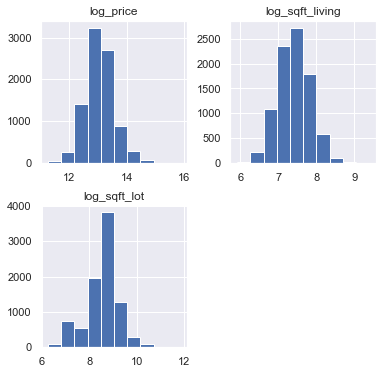

In [82]:
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = (np.log(first_model['sqft_living']))
data_log['log_sqft_lot'] = (np.log(first_model['sqft_lot']))
data_log['log_price'] = (np.log(first_model['price']))
data_log.hist(figsize  = [6, 6]);

In [83]:
data_log

log_sqft_living  log_sqft_lot  log_price
0             7.073270      8.639411  12.309982
1             7.851661      8.887653  13.195614
3             7.580700      8.517193  13.311329
7             6.966024      9.181015  12.583995
8             7.484369      8.918650  12.343658
...                ...           ...        ...
21591         7.177782      7.165493  13.071070
21592         7.333023      7.030857  12.793859
21593         7.745003      8.667852  12.899220
21594         6.927558      7.207860  12.904459
21596         6.927558      6.981006  12.691580

[8882 rows x 3 columns]

In [84]:
X_cols

['sqft_living',
 'sqft_lot',
 'wtr_1.0',
 'bed_2',
 'bed_3',
 'bed_4',
 'bed_5',
 'bed_6',
 'bed_7',
 'bed_8',
 'bed_9',
 'bath_0.75',
 'bath_1.0',
 'bath_1.25',
 'bath_1.5',
 'bath_1.75',
 'bath_2.0',
 'bath_2.25',
 'bath_2.5',
 'bath_2.75',
 'bath_3.0',
 'bath_3.25',
 'bath_3.5',
 'bath_3.75',
 'bath_4.0',
 'bath_4.25',
 'bath_4.5',
 'bath_4.75',
 'bath_5.0',
 'bath_5.25',
 'bath_5.5',
 'bath_5.75',
 'bath_6.25',
 'bath_6.75',
 'bath_7.5',
 'bath_8.0',
 'flr_1.5',
 'flr_2.0',
 'flr_2.5',
 'flr_3.0',
 'flr_3.5',
 'zip_98103',
 'zip_98105',
 'zip_98106',
 'zip_98107',
 'zip_98108',
 'zip_98109',
 'zip_98112',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98136',
 'zip_98144',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98199',
 'age_(20, 40]',
 'age_(40, 60]',
 'age_(60, 80]',
 'age_(80, 100]',
 'age_(100, 120]']

To start, I will drop all of the `bathroom` data because they are multicollinear with `sqft_living`, what may be the strongest predictor for `price`.

In [85]:
second_model = first_model.drop(columns=['bath_0.75','bath_1.0',
 'bath_1.25',
 'bath_1.5',
 'bath_1.75',
 'bath_2.0',
 'bath_2.25',
 'bath_2.5',
 'bath_2.75',
 'bath_3.0',
 'bath_3.25',
 'bath_3.5',
 'bath_3.75',
 'bath_4.0',
 'bath_4.25',
 'bath_4.5',
 'bath_4.75',
 'bath_5.0',
 'bath_5.25',
 'bath_5.5',
 'bath_5.75',
 'bath_6.25',
 'bath_6.75',
 'bath_7.5',
 'bath_8.0'],)

In [86]:
second_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 51 columns):
id                8882 non-null int64
price             8882 non-null float64
sqft_living       8882 non-null int64
sqft_lot          8882 non-null int64
wtr_1.0           8882 non-null uint8
bed_2             8882 non-null uint8
bed_3             8882 non-null uint8
bed_4             8882 non-null uint8
bed_5             8882 non-null uint8
bed_6             8882 non-null uint8
bed_7             8882 non-null uint8
bed_8             8882 non-null uint8
bed_9             8882 non-null uint8
flr_1.5           8882 non-null uint8
flr_2.0           8882 non-null uint8
flr_2.5           8882 non-null uint8
flr_3.0           8882 non-null uint8
flr_3.5           8882 non-null uint8
zip_98103         8882 non-null uint8
zip_98105         8882 non-null uint8
zip_98106         8882 non-null uint8
zip_98107         8882 non-null uint8
zip_98108         8882 non-null uint8
zip_98109       

Concatenating the logged continuous variables to the dataframe for the second model, which does not contain `bathroom` data.

In [87]:
log_model = pd.concat([data_log, second_model], axis=1)

In [88]:
log_model

log_sqft_living  log_sqft_lot  log_price          id     price  \
0             7.073270      8.639411  12.309982  7129300520  221900.0   
1             7.851661      8.887653  13.195614  6414100192  538000.0   
3             7.580700      8.517193  13.311329  2487200875  604000.0   
7             6.966024      9.181015  12.583995  2008000270  291850.0   
8             7.484369      8.918650  12.343658  2414600126  229500.0   
...                ...           ...        ...         ...       ...   
21591         7.177782      7.165493  13.071070  2997800021  475000.0   
21592         7.333023      7.030857  12.793859   263000018  360000.0   
21593         7.745003      8.667852  12.899220  6600060120  400000.0   
21594         6.927558      7.207860  12.904459  1523300141  402101.0   
21596         6.927558      6.981006  12.691580  1523300157  325000.0   

       sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  bed_4  bed_5  bed_6  \
0             1180      5650        0      0      1      0      0      0   
1             2570      7242        0      0      1      0      0      0   
3             1960      5000        0      0      0      1      0      0   
7             1060      9711        0      0      1      0      0      0   
8             1780      7470        0      0      1      0      0      0   
...            ...       ...      ...    ...    ...    ...    ...    ...   
21591         1310      1294        0      0      1      0      0      0   
21592         1530      1131        0      0      1      0      0      0   
21593         2310      5813        0      0      0      1      0      0   
21594         1020      1350        0      1      0      0      0      0   
21596         1020      1076        0      1      0      0      0      0   

       bed_7  bed_8  bed_9  flr_1.5  flr_2.0  flr_2.5  flr_3.0  flr_3.5  \
0          0      0      0        0        0        0        0        0   
1          0      0      0        0        1        0        0        0   
3          0      0      0        0        0        0        0        0   
7          0      0      0        0        0        0        0        0   
8          0      0      0        0        0        0        0        0   
...      ...    ...    ...      ...      ...      ...      ...      ...   
21591      0      0      0        0        1        0        0        0   
21592      0      0      0        0        0        0        1        0   
21593      0      0      0        0        1        0        0        0   
21594      0      0      0        0        1        0        0        0   
21596      0      0      0        0        1        0        0        0   

       zip_98103  zip_98105  zip_98106  zip_98107  zip_98108  zip_98109  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21591          0          0          0          0          0          0   
21592          1          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   
21596          0          0          0          0          0          0   

       zip_98112  zip_98115  zip_98116  zip_98117  zip_98118  zip_98119  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0  

In [89]:
log_model = log_model.drop(columns=['price', 'sqft_living', 'sqft_lot'])

In [90]:
log_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8882 entries, 0 to 21596
Data columns (total 51 columns):
log_sqft_living    8882 non-null float64
log_sqft_lot       8882 non-null float64
log_price          8882 non-null float64
id                 8882 non-null int64
wtr_1.0            8882 non-null uint8
bed_2              8882 non-null uint8
bed_3              8882 non-null uint8
bed_4              8882 non-null uint8
bed_5              8882 non-null uint8
bed_6              8882 non-null uint8
bed_7              8882 non-null uint8
bed_8              8882 non-null uint8
bed_9              8882 non-null uint8
flr_1.5            8882 non-null uint8
flr_2.0            8882 non-null uint8
flr_2.5            8882 non-null uint8
flr_3.0            8882 non-null uint8
flr_3.5            8882 non-null uint8
zip_98103          8882 non-null uint8
zip_98105          8882 non-null uint8
zip_98106          8882 non-null uint8
zip_98107          8882 non-null uint8
zip_98108          8882 non-

In [91]:
X_cols = [c for c in log_model.columns.to_list() if c not in ['log_price', 'id']]

In [92]:
X_cols

['log_sqft_living',
 'log_sqft_lot',
 'wtr_1.0',
 'bed_2',
 'bed_3',
 'bed_4',
 'bed_5',
 'bed_6',
 'bed_7',
 'bed_8',
 'bed_9',
 'flr_1.5',
 'flr_2.0',
 'flr_2.5',
 'flr_3.0',
 'flr_3.5',
 'zip_98103',
 'zip_98105',
 'zip_98106',
 'zip_98107',
 'zip_98108',
 'zip_98109',
 'zip_98112',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98136',
 'zip_98144',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98199',
 'age_(20, 40]',
 'age_(40, 60]',
 'age_(60, 80]',
 'age_(80, 100]',
 'age_(100, 120]']

In [93]:
X = log_model[X_cols]
y = log_model['log_price']

In [94]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.summary()

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     689.6
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:37:55   Log-Likelihood:                 425.56
No. Observations:                8882   AIC:                            -751.1
Df Residuals:                    8832   BIC:                            -396.5
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.5231      0.071    106.624      0.000       7.385       7.661
log_sqft_living     0.6599      0.010     68.792      0.000       0.641       0.679
log_sqft_lot        0.1331      0.006     20.722      0.000       0.121       0.146
wtr_1.0             0.6890      0.030     23.322      0.000       0.631       0.747
bed_2              -0.0269      0.021     -1.309      0.191      -0.067       0.013
bed_3              -0.0733      0.021     -3.485      0.000      -0.114      -0.032
bed_4              -0.0879      0.022     -3.973      0.000      -0.131      -0.045
bed_5              -0.1387      0.024     -5.732      0.000      -0.186      -0.091
bed_6              -0.1741      0.030     -5.727      0.000      -0.234      -0.115
bed_7              -0.3040      0.056     -5.461      0.000      -0.413      -0.195
bed_8              -0.2945      0.086     -3.426      0.001      -0.463      -0.126
bed_9              -0.4839      0.098     -4.942      0.000      -0.676      -0.292
flr_1.5             0.0097      0.008      1.180      0.238      -0.006       0.026
flr_2.0             0.0952      0.009     10.758      0.000       0.078       0.113
flr_2.5             0.1492      0.025      6.028      0.000       0.101       0.198
flr_3.0             0.0948      0.015      6.430      0.000       0.066       0.124
flr_3.5             0.1762      0.089      1.981      0.048       0.002       0.351
zip_98103          -0.1974      0.025     -7.935      0.000      -0.246      -0.149
zip_98105          -0.0540      0.028     -1.953      0.051      -0.108       0.000
zip_98106          -0.7399      0.027    -27.733      0.000      -0.792      -0.688
zip_98107          -0.1514      0.027     -5.598      0.000      -0.204      -0.098
zip_98108          -0.7296      0.029    -25.326      0.000      -0.786      -0.673
zip_98109           0.0228      0.032      0.718      0.473      -0.040       0.085
zip_98112           0.0552      0.027      2.055      0.040       0.003       0.108
zip_98115          -0.2396      0.025     -9.538      0.000      -0.289      -0.190
zip_98116          -0.2504      0.026     -9.509      0.000      -0.302      -0.199
zip_98117          -0.2323      0.025     -9.245      0.000      -0.282      -0.183
zip_98118          -0.6188      0.025    -24.320      0.000      -0.669      -0.569
zip_98119           0.0102      0.028      0.359      0.720      -0.046       0.066
zip_98122          -0.1893      0.027     -7.132      0.000      -0.241      -0.137
zip_98125          -0.5206      0.026    -19.750      0.000      -0.572      -0.469
zip_98126          -0.5038      0.026    -19.135      0.000      -0.555      -0.452
zip_98133          -0.6235      0.026    -24.104      0.000      -0.674      -0.573
zip_98136          -0.3445      0.027    -12.664      0.000

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [96]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [97]:
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error V1: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Root Mean Squared Error V2: {mean_squared_error(y_test, y_test_pred, squared=False)}")

Training Scores:
R2: 0.7933674826674522
Mean Absolute Error: 0.17343672996531737
---
Testing Scores:
R2: 0.7897050078532215
Mean Absolute Error: 0.17682014972990237
Root Mean Squared Error V1: 0.2344659744259511
Root Mean Squared Error V2: 0.2344659744259511


This model is just slightly overfit, but the MAE and RMSE have both dropped significantly. I'll address the outliers in this next model. I'll start with the continuous data and move onto the categorical data.

Below are the coefficient weights.

In [98]:
pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')[0].sort_values()

zip_98168         -0.184412
zip_98198         -0.175600
zip_98178         -0.160670
zip_98146         -0.146060
zip_98155         -0.145448
zip_98118         -0.140012
zip_98133         -0.137189
zip_98106         -0.136305
zip_98188         -0.129413
zip_98166         -0.128506
zip_98125         -0.106042
zip_98108         -0.104923
zip_98126         -0.097979
zip_98148         -0.078955
zip_98177         -0.067097
zip_98144         -0.064566
zip_98115         -0.057542
zip_98117         -0.055723
zip_98136         -0.055664
zip_98103         -0.046702
zip_98116         -0.045861
bed_3             -0.036502
bed_4             -0.035887
zip_98122         -0.035396
bed_5             -0.030269
zip_98107         -0.023843
zip_98199         -0.022968
bed_6             -0.020885
age_(40, 60]      -0.019148
bed_7             -0.016095
bed_9             -0.014461
age_(20, 40]      -0.012189
bed_8             -0.010316
bed_2             -0.009794
age_(60, 80]      -0.009432
zip_98105         -0

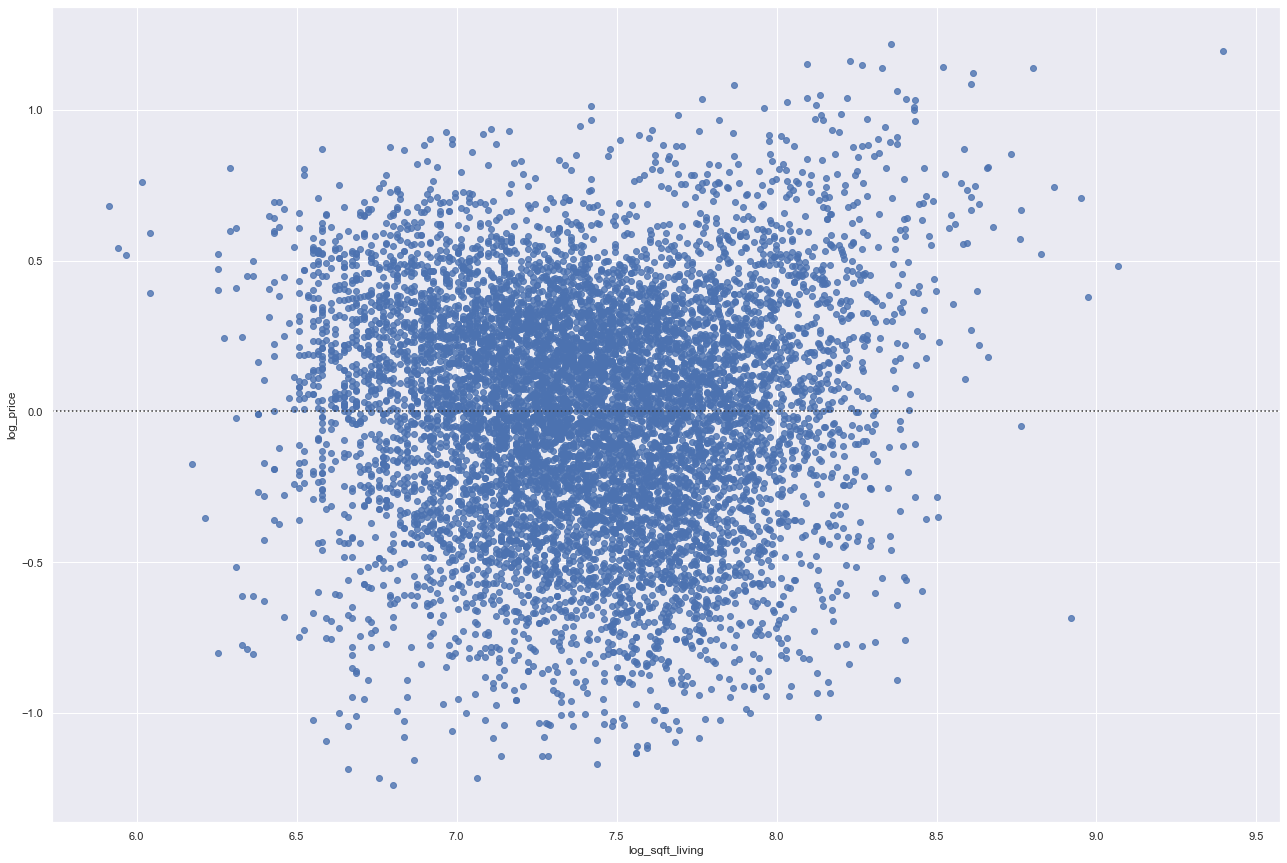

In [99]:
sns.residplot('log_sqft_living','log_price', data=log_model)

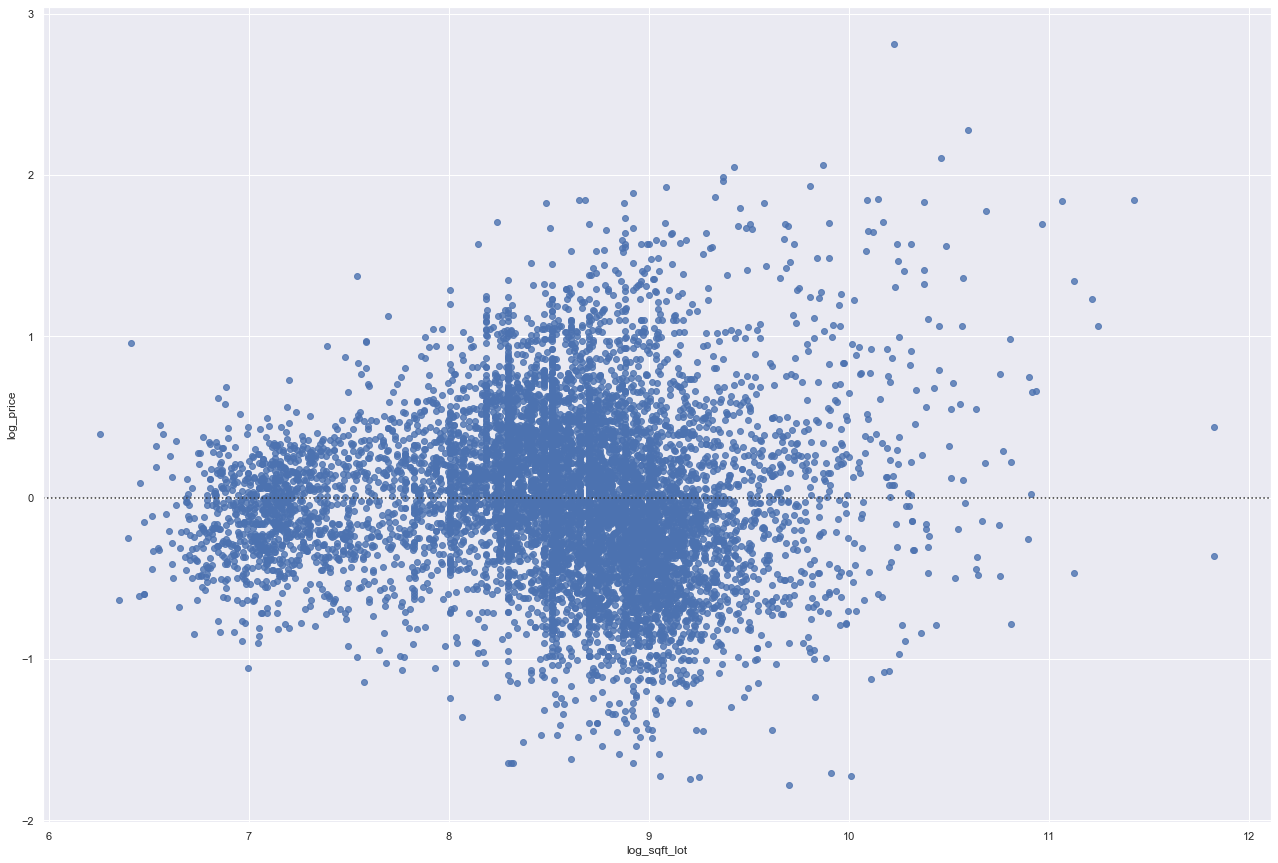

In [100]:
#heteroscedastic
sns.residplot('log_sqft_lot', 'log_price', data=log_model)

## Second Model

In [101]:
#looking at ranges for continuous data
second_model.describe()

id         price   sqft_living       sqft_lot      wtr_1.0  \
count  8.882000e+03  8.882000e+03   8882.000000    8882.000000  8882.000000   
mean   4.605114e+09  5.357668e+05   1797.751520    6453.661675     0.007431   
std    2.843545e+09  3.416391e+05    799.502885    5445.870438     0.085886   
min    1.200019e+06  7.800000e+04    370.000000     520.000000     0.000000   
25%    2.172000e+09  3.375000e+05   1240.000000    3881.750000     0.000000   
50%    4.023204e+09  4.530000e+05   1640.000000    5559.500000     0.000000   
75%    7.234601e+09  6.300000e+05   2190.000000    7807.750000     0.000000   
max    9.900000e+09  7.700000e+06  12050.000000  137214.000000     1.000000   

             bed_2        bed_3        bed_4        bed_5        bed_6  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.225287     0.442130     0.236884     0.061360     0.014749   
std       0.417795     0.496668     0.425194     0.240003     0.120553   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             bed_7        bed_8        bed_9      flr_1.5      flr_2.0  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.002364     0.000901     0.000676     0.156609     0.239811   
std       0.048570     0.030000     0.025984     0.363452     0.426992   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           flr_2.5      flr_3.0      flr_3.5    zip_98103    zip_98105  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.011484     0.062824     0.000788     0.067440     0.025670   
std       0.106552     0.242659     0.028064     0.250796     0.158157   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         zip_98106    zip_98107    zip_98108    zip_98109    zip_98112  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.037041     0.029723     0.020829     0.012272     0.030173   
std       0.188873     0.169832     0.142818     0.110103     0.171074   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         zip_98115    zip_98116    zip_98117    zip_98118    zip_98119  \
count  8882.000000  8882.000000  8882.000000  8882.000000  8882.000000   
mean      0.064850     0.037041     0.061698     0.056068     0.020716   
std       0.246275     0.188873     0.240619     0.230067     0.142440   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000 

In [102]:
second_model.sort_values(by='sqft_lot', ascending=False).head(200)

id      price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
18049  9537200037   320000.0         1310    137214        0      0      0   
12414  7680400140   710000.0         3740    136915        0      0      1   
6396   2624049091  2900000.0         3750     91681        1      0      0   
2123   4379600030  1330000.0         6400     76665        0      0      1   
11717  2303900045  1580000.0         4570     74487        0      0      0   
12449   182000350   287500.0         2020     67953        0      0      0   
15152  3304700130  1760000.0         3860     67953        0      0      0   
14542  2303900035  2890000.0         8670     64033        0      0      0   
17544  7631800015  2510000.0         5480     57990        1      0      1   
10615  3585300445   892500.0         2120     56192        0      0      1   
12219   617000030   887500.0         4230     54977        0      0      1   
7505   1154100515   470000.0         2770     54707        0      0      1   
17881  7110000068   975000.0         2520     54160        1      0      0   
11544  2013802030   357000.0         2460     53882        1      0      1   
9121   2011400230   575000.0         3690     49709        0      0      0   
18466  2123049086   210000.0          840     49658        0      1      0   
18707  7204200025  1230000.0         3120     49456        1      0      0   
17688  3438502290   616750.0         2140     47743        0      0      1   
1017   1623049214   283000.0         1480     47045        0      0      0   
1259   7636800041   995000.0         4380     47044        1      0      1   
2978   3744600028   390000.0         2690     46609        0      0      0   
5961   5249800010  2730000.0         6410     43838        0      0      0   
16012  7680400050   571000.0         2280     43560        0      0      0   
8404      1200021   400000.0         1460     43000        0      0      1   
13371  2787000040   285000.0         1870     42070        0      0      1   
1074   6099400030   320000.0         2300     41900        0      0      1   
4020   9175600025   800000.0         7480     41664        0      0      0   
13474  7340601063   295500.0         1590     41550        0      0      1   
2624   7738500731  4500000.0         6640     40014        1      0      0   
6362   4017110020   445800.0         2070     39446        0      0      0   
15498  4030100005  1800000.0         4320     39094        1      0      0   
17320  2105200010   515000.0         2030     39049        0      0      0   
4422   7781600100  1340000.0         2730     38869        0      0      1   
15673  3585900190   825000.0         3400     38400        0      0      1   
3328   2011400405   380000.0         1320     38125        0      0      0   
6373   9169600275   280000.0         2280     37500        0      1      0   
7865   1454100650   942000.0         3160     37200        0      0      0   
15713  6116500290   799950.0         3040     36721        0      0      0   
8410   4027700594   520000.0         2310     36665        0      0      1   
14971  8665900168   635000.0         4260     36360        0      0      0   
16600  7935000280  2200000.0         5210     35765        0      0      0   
19002  2303900100  3800000.0         5510     35000        0      0      1   
6471   7936500190  1340000.0         2130     34689        1      0      0   
6505   1024039049  1020000.0         2920     34527        0      0      1   
794    1623049062   210000.0          750     34133        0      1      0   
8492   4019300155   911100.0         3330     33826        0      0      0   
15501  3361402066   365000.0         3080     32997        0      0      0   
16708   798000630   340000.0         2020     32710        0      0      0   
19342  3585300194  1400000.0         4140     32700        0      0      0   
14216  1447600410   290000.0         1480     32700        0      0      1   
13249  2011400021   392000.0         

In [103]:
second_model = second_model[second_model['sqft_lot']<40000]

In [104]:
second_model.sort_values(by='sqft_lot', ascending=False).head(200)

id      price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
6362   4017110020   445800.0         2070     39446        0      0      0   
15498  4030100005  1800000.0         4320     39094        1      0      0   
17320  2105200010   515000.0         2030     39049        0      0      0   
4422   7781600100  1340000.0         2730     38869        0      0      1   
15673  3585900190   825000.0         3400     38400        0      0      1   
3328   2011400405   380000.0         1320     38125        0      0      0   
6373   9169600275   280000.0         2280     37500        0      1      0   
7865   1454100650   942000.0         3160     37200        0      0      0   
15713  6116500290   799950.0         3040     36721        0      0      0   
8410   4027700594   520000.0         2310     36665        0      0      1   
14971  8665900168   635000.0         4260     36360        0      0      0   
16600  7935000280  2200000.0         5210     35765        0      0      0   
19002  2303900100  3800000.0         5510     35000        0      0      1   
6471   7936500190  1340000.0         2130     34689        1      0      0   
6505   1024039049  1020000.0         2920     34527        0      0      1   
794    1623049062   210000.0          750     34133        0      1      0   
8492   4019300155   911100.0         3330     33826        0      0      0   
15501  3361402066   365000.0         3080     32997        0      0      0   
16708   798000630   340000.0         2020     32710        0      0      0   
14216  1447600410   290000.0         1480     32700        0      0      1   
19342  3585300194  1400000.0         4140     32700        0      0      0   
13249  2011400021   392000.0         3740     32481        0      0      0   
20748  9536600810   380000.0         1984     32400        0      0      0   
9488   3586500770   808000.0         2590     32380        0      0      1   
17298  3585901025  1740000.0         4310     32093        0      0      1   
3154   1827200265  1900000.0         3690     32044        1      1      0   
4186   2303900090  2880000.0         5760     32033        0      0      0   
9036   3586501075   600000.0         2840     31720        0      0      0   
7941    257000037   200000.0         2120     31564        0      0      1   
3114   4019300195   900000.0         2990     30869        0      0      1   
14483  3585300410   729000.0         1770     30689        0      0      1   
4410   8108600464   335000.0         2150     30476        0      0      1   
18682  1623049241   335000.0         2390     30409        0      0      1   
20330  5379805260   400200.0         2260     30250        0      0      0   
19316   123039176   399888.0         2370     30200        0      0      0   
18942   327000165  1150000.0         2330     30122        0      0      0   
14172  1333300145  2230000.0         4200     30120        0      0      1   
6310   4027701253   470000.0         1990     30083        0      0      0   
7773   3023049186   575000.0         2500     30056        0      0      1   
2454   7632400400  1050000.0         3190     29982        0      0      1   
17876  9289900065   440000.0         2100     29735        0      0      1   
10775  6411600370   475000.0         2870     29699        0      0      0   
5868   9141100255   438000.0         1950     29347        0      1      0   
8206   2144800615   190000.0          930     29258        0      0      0   
4214   1025039086  1880000.0         3280     29111        1      0      1   
12732  7247000035   210000.0         2180     28710        0      0      0   
1083   6114600030   675000.0         2690     28300        0      0      0   
11619  3585900045  1250000.0         2960     28300        0      0      0   
8789   2613200025   175000.0         1330     28270        0      1      0   
5099   9289100170   569950.0         2510     28185        0      0      0   
17665  3585901085  2010000.0         

In [105]:
second_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8853 entries, 0 to 21596
Data columns (total 51 columns):
id                8853 non-null int64
price             8853 non-null float64
sqft_living       8853 non-null int64
sqft_lot          8853 non-null int64
wtr_1.0           8853 non-null uint8
bed_2             8853 non-null uint8
bed_3             8853 non-null uint8
bed_4             8853 non-null uint8
bed_5             8853 non-null uint8
bed_6             8853 non-null uint8
bed_7             8853 non-null uint8
bed_8             8853 non-null uint8
bed_9             8853 non-null uint8
flr_1.5           8853 non-null uint8
flr_2.0           8853 non-null uint8
flr_2.5           8853 non-null uint8
flr_3.0           8853 non-null uint8
flr_3.5           8853 non-null uint8
zip_98103         8853 non-null uint8
zip_98105         8853 non-null uint8
zip_98106         8853 non-null uint8
zip_98107         8853 non-null uint8
zip_98108         8853 non-null uint8
zip_98109       

In [106]:
second_model

id     price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
0      7129300520  221900.0         1180      5650        0      0      1   
1      6414100192  538000.0         2570      7242        0      0      1   
3      2487200875  604000.0         1960      5000        0      0      0   
7      2008000270  291850.0         1060      9711        0      0      1   
8      2414600126  229500.0         1780      7470        0      0      1   
...           ...       ...          ...       ...      ...    ...    ...   
21591  2997800021  475000.0         1310      1294        0      0      1   
21592   263000018  360000.0         1530      1131        0      0      1   
21593  6600060120  400000.0         2310      5813        0      0      0   
21594  1523300141  402101.0         1020      1350        0      1      0   
21596  1523300157  325000.0         1020      1076        0      1      0   

       bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  flr_1.5  flr_2.0  flr_2.5  \
0          0      0      0      0      0      0        0        0        0   
1          0      0      0      0      0      0        0        1        0   
3          1      0      0      0      0      0        0        0        0   
7          0      0      0      0      0      0        0        0        0   
8          0      0      0      0      0      0        0        0        0   
...      ...    ...    ...    ...    ...    ...      ...      ...      ...   
21591      0      0      0      0      0      0        0        1        0   
21592      0      0      0      0      0      0        0        0        0   
21593      1      0      0      0      0      0        0        1        0   
21594      0      0      0      0      0      0        0        1        0   
21596      0      0      0      0      0      0        0        1        0   

       flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  zip_98107  \
0            0        0          0          0          0          0   
1            0        0          0          0          0          0   
3            0        0          0          0          0          0   
7            0        0          0          0          0          0   
8            0        0          0          0          0          0   
...        ...      ...        ...        ...        ...        ...   
21591        0        0          0          0          0          0   
21592        1        0          1          0          0          0   
21593        0        0          0          0          0          0   
21594        0        0          0          0          0          0   
21596        0        0          0          0          0          0   

       zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  zip_98117  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21591          0          0          0          0          1          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   
21596          0          0          0          0          0          0   

       zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  zip_98133  \
0              0          0          0          0          0          0   
1              0          0          0          1          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0        

In [107]:
second_model.describe()

id         price   sqft_living      sqft_lot      wtr_1.0  \
count  8.853000e+03  8.853000e+03   8853.000000   8853.000000  8853.000000   
mean   4.605709e+09  5.338992e+05   1792.088445   6280.103242     0.006664   
std    2.843530e+09  3.354335e+05    786.465439   4311.252953     0.081368   
min    1.200019e+06  7.800000e+04    370.000000    520.000000     0.000000   
25%    2.172001e+09  3.375000e+05   1240.000000   3880.000000     0.000000   
50%    4.023500e+09  4.529500e+05   1640.000000   5525.000000     0.000000   
75%    7.234600e+09  6.300000e+05   2190.000000   7800.000000     0.000000   
max    9.900000e+09  7.700000e+06  12050.000000  39446.000000     1.000000   

             bed_2        bed_3        bed_4        bed_5        bed_6  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.225912     0.442110     0.236869     0.060883     0.014684   
std       0.418205     0.496665     0.425185     0.239130     0.120293   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             bed_7        bed_8        bed_9      flr_1.5      flr_2.0  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.002259     0.000904     0.000678     0.156444     0.239354   
std       0.047479     0.030049     0.026026     0.363296     0.426713   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           flr_2.5      flr_3.0      flr_3.5    zip_98103    zip_98105  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.011296     0.063029     0.000791     0.067661     0.025754   
std       0.105685     0.243030     0.028110     0.251177     0.158409   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         zip_98106    zip_98107    zip_98108    zip_98109    zip_98112  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.037050     0.029820     0.020897     0.012312     0.030272   
std       0.188894     0.170101     0.143047     0.110281     0.171345   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         zip_98115    zip_98116    zip_98117    zip_98118    zip_98119  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.065063     0.037163     0.061900     0.056139     0.020784   
std       0.246650     0.189171     0.240987     0.230203     0.142668   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000

In [108]:
second_model.sort_values(by='sqft_living', ascending=False).head(200)

id      price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
7245   6762700020  7700000.0        12050     27600        0      0      0   
13398  2426039123  2420000.0         7880     24250        0      0      0   
18462  1346300150  3300000.0         7710     11750        0      0      0   
7900   1068000375  3200000.0         7100     18200        0      0      0   
4807   9831200500  2480000.0         6810      7500        0      0      0   
5697   1118002000  2470000.0         6390     13180        0      0      0   
7184   7159200005  3200000.0         6210      8856        0      0      0   
6189   9185700440  2400000.0         5860      7200        0      0      0   
3809   1118000301  2890000.0         5780      7173        0      0      0   
15035  8924600020  1540000.0         5770     10050        0      0      0   
4186   2303900090  2880000.0         5760     32033        0      0      0   
4028   5700003585  2500000.0         5620     12672        0      0      0   
1846   3271800295  1570000.0         5620      5800        0      0      0   
18192  9471200065  1860000.0         5570      9600        0      0      0   
18394  2397101606  2630000.0         5540      7200        0      0      0   
19002  2303900100  3800000.0         5510     35000        0      0      1   
6502   4217402115  3650000.0         5480     19401        1      0      0   
14499  6169900790  2400000.0         5480     10800        0      0      0   
14760  9412400220  1610000.0         5470     18200        1      0      0   
3381   1118001408  2540000.0         5410     13431        0      0      0   
540     622049114  2130000.0         5403     24069        1      0      1   
13757  1795800040  1350000.0         5370     20388        0      0      0   
14017  5316101075  2890000.0         5350     14400        0      0      0   
3515   5700003640  2100000.0         5340     10655        0      0      0   
11213  6613000935  2560000.0         5300     26211        1      0      0   
16600  7935000280  2200000.0         5210     35765        0      0      0   
15654  4030100290  1680000.0         5170      7197        1      0      0   
17274  5316100920  2250000.0         5150      7800        0      0      1   
16706  1338800425  2140000.0         5110      7128        0      0      0   
2038   9471200200  2530000.0         5040     16048        0      0      0   
2862   4114601570  3600000.0         5020     12431        1      0      1   
17387  6819100020  1430000.0         4960      6000        0      0      0   
6386   4058801702   800000.0         4940     10037        0      0      0   
17946  8952900245   850000.0         4920     20590        0      0      0   
3335   1959701745  1680000.0         4910      6600        0      0      0   
7120   1024049024  1740000.0         4870      7700        0      0      0   
779    1954700695  2250000.0         4860      9453        0      0      0   
9405   5700003630  1930000.0         4830      8050        0      0      0   
7408   5017000470  1980000.0         4800      9097        0      0      0   
518    4386700135  2250000.0         4760      8036        0      0      0   
20749  5428000070   770000.0         4750      8234        0      0      0   
5112   9412400185  1310000.0         4750     13912        0      0      0   
3731   1118000110  2450000.0         4730     13586        0      0      0   
5844   3585900500  1530000.0         4720     21000        0      0      0   
18867  4218400455  2180000.0         4710     11000        0      0      0   
19989   148000475  1400000.0         4700      9160        0      0      0   
11933  8128600060   600000.0         4690     14930        0      0      0   
4855   1338300170  2050000.0         4690      8208        0      0      0   
15678  6117502230  1640000.0         4660     21164        1      0      1   
18753  1959701800  2150000.0         4660      5500        0      0      1   
19912  6600000217  1600000.0         

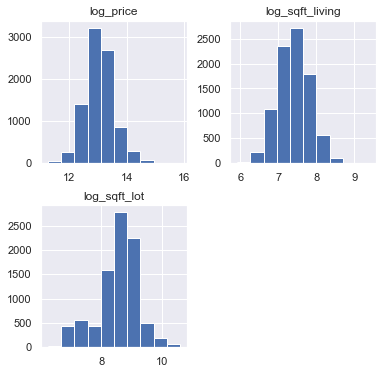

In [109]:
log_sec_mod = pd.DataFrame([])
log_sec_mod['log_sqft_living'] = (np.log(second_model['sqft_living']))
log_sec_mod['log_sqft_lot'] = (np.log(second_model['sqft_lot']))
log_sec_mod['log_price'] = (np.log(second_model['price']))
log_sec_mod.hist(figsize  = [6, 6]);

In [110]:
log_sec_mod

log_sqft_living  log_sqft_lot  log_price
0             7.073270      8.639411  12.309982
1             7.851661      8.887653  13.195614
3             7.580700      8.517193  13.311329
7             6.966024      9.181015  12.583995
8             7.484369      8.918650  12.343658
...                ...           ...        ...
21591         7.177782      7.165493  13.071070
21592         7.333023      7.030857  12.793859
21593         7.745003      8.667852  12.899220
21594         6.927558      7.207860  12.904459
21596         6.927558      6.981006  12.691580

[8853 rows x 3 columns]

## Third Model

The residuals above indicate heteroscedasticity in the `log_sqft_lot` variable. I want to take care of that while minimizing data loss.

In [111]:
third_model = pd.concat([log_sec_mod, second_model], axis=1)

In [112]:
third_model.drop(columns=['sqft_living', 'sqft_lot', 'price'], inplace=True)

In [113]:
third_model

log_sqft_living  log_sqft_lot  log_price          id  wtr_1.0  bed_2  \
0             7.073270      8.639411  12.309982  7129300520        0      0   
1             7.851661      8.887653  13.195614  6414100192        0      0   
3             7.580700      8.517193  13.311329  2487200875        0      0   
7             6.966024      9.181015  12.583995  2008000270        0      0   
8             7.484369      8.918650  12.343658  2414600126        0      0   
...                ...           ...        ...         ...      ...    ...   
21591         7.177782      7.165493  13.071070  2997800021        0      0   
21592         7.333023      7.030857  12.793859   263000018        0      0   
21593         7.745003      8.667852  12.899220  6600060120        0      0   
21594         6.927558      7.207860  12.904459  1523300141        0      1   
21596         6.927558      6.981006  12.691580  1523300157        0      1   

       bed_3  bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  flr_1.5  flr_2.0  \
0          1      0      0      0      0      0      0        0        0   
1          1      0      0      0      0      0      0        0        1   
3          0      1      0      0      0      0      0        0        0   
7          1      0      0      0      0      0      0        0        0   
8          1      0      0      0      0      0      0        0        0   
...      ...    ...    ...    ...    ...    ...    ...      ...      ...   
21591      1      0      0      0      0      0      0        0        1   
21592      1      0      0      0      0      0      0        0        0   
21593      0      1      0      0      0      0      0        0        1   
21594      0      0      0      0      0      0      0        0        1   
21596      0      0      0      0      0      0      0        0        1   

       flr_2.5  flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  zip_98107  \
0            0        0        0          0          0          0          0   
1            0        0        0          0          0          0          0   
3            0        0        0          0          0          0          0   
7            0        0        0          0          0          0          0   
8            0        0        0          0          0          0          0   
...        ...      ...      ...        ...        ...        ...        ...   
21591        0        0        0          0          0          0          0   
21592        0        1        0          1          0          0          0   
21593        0        0        0          0          0          0          0   
21594        0        0        0          0          0          0          0   
21596        0        0        0          0          0          0          0   

       zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  zip_98117  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21591          0          0          0          0          1          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   
21596          0          0          0          0          0          0   

       zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  zip_98133  \
0              0          0          0          0          0          0   
1              0          0          0          1          0          0   
3              0          0          0          0         

In [114]:
X_cols = [c for c in third_model.columns.to_list() if c not in ['log_price', 'id']]

In [115]:
X = third_model[X_cols]
y = third_model['log_price']

In [116]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.summary()

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     682.0
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:37:58   Log-Likelihood:                 436.33
No. Observations:                8853   AIC:                            -772.7
Df Residuals:                    8803   BIC:                            -418.2
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.5223      0.071    105.668      0.000       7.383       7.662
log_sqft_living     0.6594      0.010     68.539      0.000       0.641       0.678
log_sqft_lot        0.1338      0.007     20.332      0.000       0.121       0.147
wtr_1.0             0.6932      0.031     22.362      0.000       0.632       0.754
bed_2              -0.0268      0.021     -1.305      0.192      -0.067       0.013
bed_3              -0.0726      0.021     -3.459      0.001      -0.114      -0.031
bed_4              -0.0881      0.022     -3.984      0.000      -0.131      -0.045
bed_5              -0.1409      0.024     -5.821      0.000      -0.188      -0.093
bed_6              -0.1728      0.030     -5.674      0.000      -0.232      -0.113
bed_7              -0.2925      0.057     -5.160      0.000      -0.404      -0.181
bed_8              -0.2941      0.086     -3.426      0.001      -0.462      -0.126
bed_9              -0.4828      0.098     -4.936      0.000      -0.675      -0.291
flr_1.5             0.0111      0.008      1.354      0.176      -0.005       0.027
flr_2.0             0.0950      0.009     10.705      0.000       0.078       0.112
flr_2.5             0.1492      0.025      5.976      0.000       0.100       0.198
flr_3.0             0.0950      0.015      6.430      0.000       0.066       0.124
flr_3.5             0.1765      0.089      1.986      0.047       0.002       0.351
zip_98103          -0.1977      0.025     -7.960      0.000      -0.246      -0.149
zip_98105          -0.0543      0.028     -1.969      0.049      -0.108      -0.000
zip_98106          -0.7411      0.027    -27.802      0.000      -0.793      -0.689
zip_98107          -0.1517      0.027     -5.617      0.000      -0.205      -0.099
zip_98108          -0.7301      0.029    -25.373      0.000      -0.787      -0.674
zip_98109           0.0227      0.032      0.715      0.474      -0.040       0.085
zip_98112           0.0553      0.027      2.060      0.039       0.003       0.108
zip_98115          -0.2402      0.025     -9.572      0.000      -0.289      -0.191
zip_98116          -0.2509      0.026     -9.540      0.000      -0.302      -0.199
zip_98117          -0.2329      0.025     -9.281      0.000      -0.282      -0.184
zip_98118          -0.6201      0.025    -24.396      0.000      -0.670      -0.570
zip_98119           0.0101      0.028      0.356      0.722      -0.046       0.066
zip_98122          -0.1894      0.027     -7.143      0.000      -0.241      -0.137
zip_98125          -0.5218      0.026    -19.811      0.000      -0.573      -0.470
zip_98126          -0.5044      0.026    -19.181      0.000      -0.556      -0.453
zip_98133          -0.6245      0.026    -24.163      0.000      -0.675      -0.574
zip_98136          -0.3451      0.027    -12.700      0.000

In [117]:
X = third_model[X_cols]
y = third_model['log_price']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [119]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [120]:
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error V1: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Root Mean Squared Error V2: {mean_squared_error(y_test, y_test_pred, squared=False)}")

Training Scores:
R2: 0.7899970636141055
Mean Absolute Error: 0.17382381953095608
---
Testing Scores:
R2: 0.7939445685183457
Mean Absolute Error: 0.17500970686567907
Root Mean Squared Error V1: 0.23389677130342817
Root Mean Squared Error V2: 0.23389677130342817


In [121]:
pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')[0].sort_values()

zip_98168         -0.189933
zip_98198         -0.184344
zip_98178         -0.159243
zip_98146         -0.150428
zip_98155         -0.147237
zip_98118         -0.146336
zip_98133         -0.143901
zip_98106         -0.138156
zip_98166         -0.129321
zip_98188         -0.127827
zip_98125         -0.111038
zip_98126         -0.102006
zip_98108         -0.101757
zip_98148         -0.083429
zip_98177         -0.070977
zip_98144         -0.069014
zip_98115         -0.063662
zip_98136         -0.059968
zip_98117         -0.059569
zip_98103         -0.054406
zip_98116         -0.048438
zip_98122         -0.037849
bed_4             -0.031403
bed_5             -0.029585
zip_98107         -0.028760
zip_98199         -0.025942
bed_3             -0.025582
bed_6             -0.020453
age_(40, 60]      -0.019039
zip_98105         -0.013454
age_(60, 80]      -0.012338
bed_7             -0.011481
bed_9             -0.011064
bed_8             -0.010288
age_(20, 40]      -0.010157
bed_2             -0

In [122]:
lr.intercept_

13.048955137901197

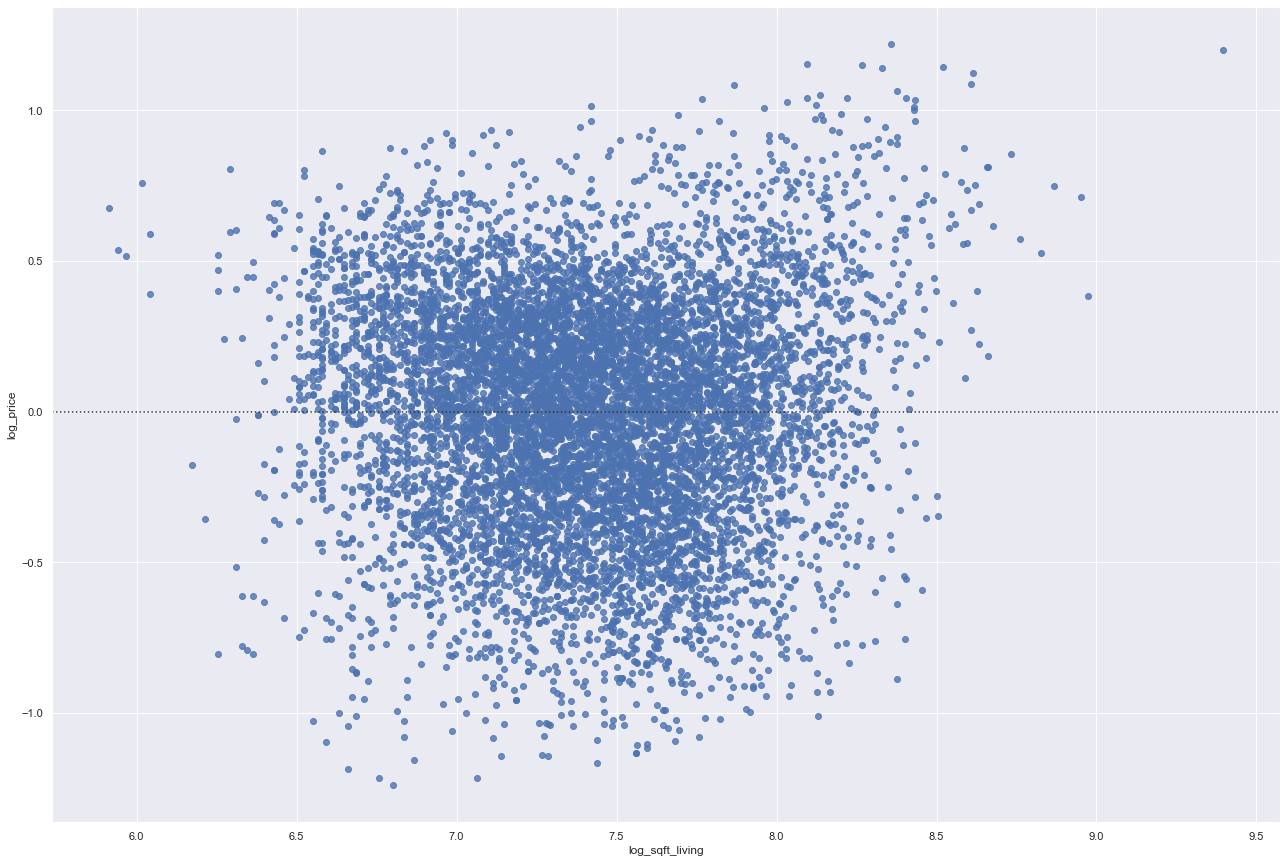

In [123]:
sns.residplot('log_sqft_living', 'log_price', data=third_model)

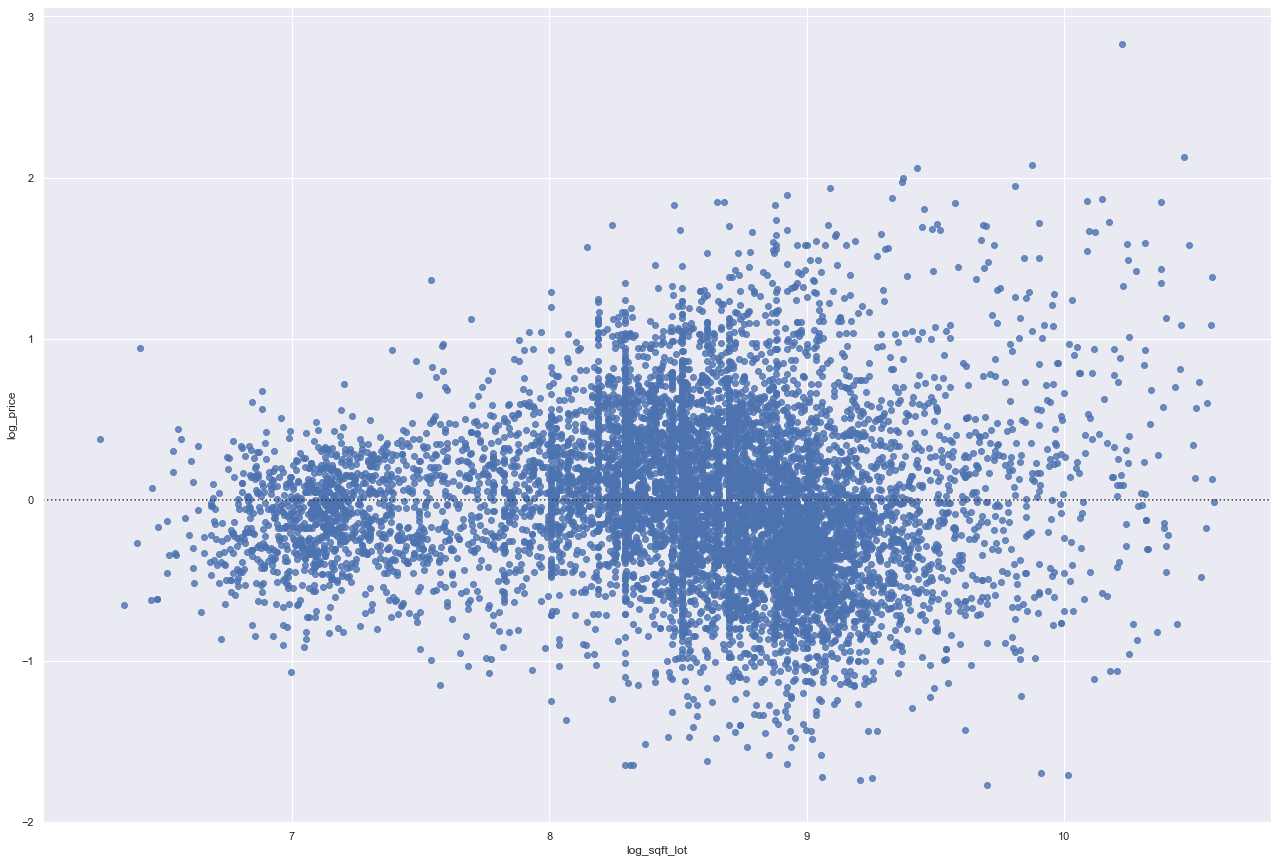

In [124]:
sns.residplot('log_sqft_lot', 'log_price', data=third_model)

In [125]:
third_model[third_model['log_sqft_lot'] <= 7]

log_sqft_living  log_sqft_lot  log_price          id  wtr_1.0  bed_2  \
63            7.339538      6.950815  13.215854  9528102996        0      0   
89            6.937314      6.971669  12.721886  3869900162        0      1   
547           6.975414      6.475433  12.468245  7899800860        0      1   
643           7.414573      6.994850  13.500115  9385200045        0      0   
666           7.106606      6.990257  12.631340  6145600041        0      0   
...                ...           ...        ...         ...      ...    ...   
21536         7.003065      6.458338  13.154831   688000017        0      0   
21553         6.887553      6.927558  12.703813  6021503705        0      1   
21568         7.138867      6.802395  12.847927   952006823        0      0   
21579         7.333023      6.888572  13.161584  1972201967        0      1   
21596         6.927558      6.981006  12.691580  1523300157        0      1   

       bed_3  bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  flr_1.5  flr_2.0  \
63         1      0      0      0      0      0      0        0        0   
89         0      0      0      0      0      0      0        0        1   
547        0      0      0      0      0      0      0        0        1   
643        1      0      0      0      0      0      0        0        0   
666        1      0      0      0      0      0      0        0        0   
...      ...    ...    ...    ...    ...    ...    ...      ...      ...   
21536      0      0      0      0      0      0      0        0        0   
21553      0      0      0      0      0      0      0        0        0   
21568      1      0      0      0      0      0      0        0        1   
21579      0      0      0      0      0      0      0        0        0   
21596      0      0      0      0      0      0      0        0        1   

       flr_2.5  flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  zip_98107  \
63           0        1        0          0          0          0          0   
89           0        0        0          0          0          0          0   
547          0        0        0          0          0          1          0   
643          0        1        0          0          0          0          0   
666          0        1        0          0          0          0          0   
...        ...      ...      ...        ...        ...        ...        ...   
21536        0        1        0          0          0          0          0   
21553        0        1        0          0          0          0          0   
21568        0        0        0          0          0          0          0   
21579        0        1        0          1          0          0          0   
21596        0        0        0          0          0          0          0   

       zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  zip_98117  \
63             0          0          0          1          0          0   
89             0          0          0          0          0          0   
547            0          0          0          0          0          0   
643            0          0          0          0          1          0   
666            0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21536          0          0          1          0          0          0   
21553          0          0          0          0          0          1   
21568          0          0          0          0          1          0   
21579          0          0          0          0          0          0   
21596          0          0          0          0          0          0   

       zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  zip_98133  \
63             0          0          0          0          0          0   
89             0          0          0          0          0          0   
547            0          0          0          0         

In [126]:
276/8940

0.03087248322147651

In [127]:
third_model = third_model[third_model['log_sqft_lot'] >= 7]

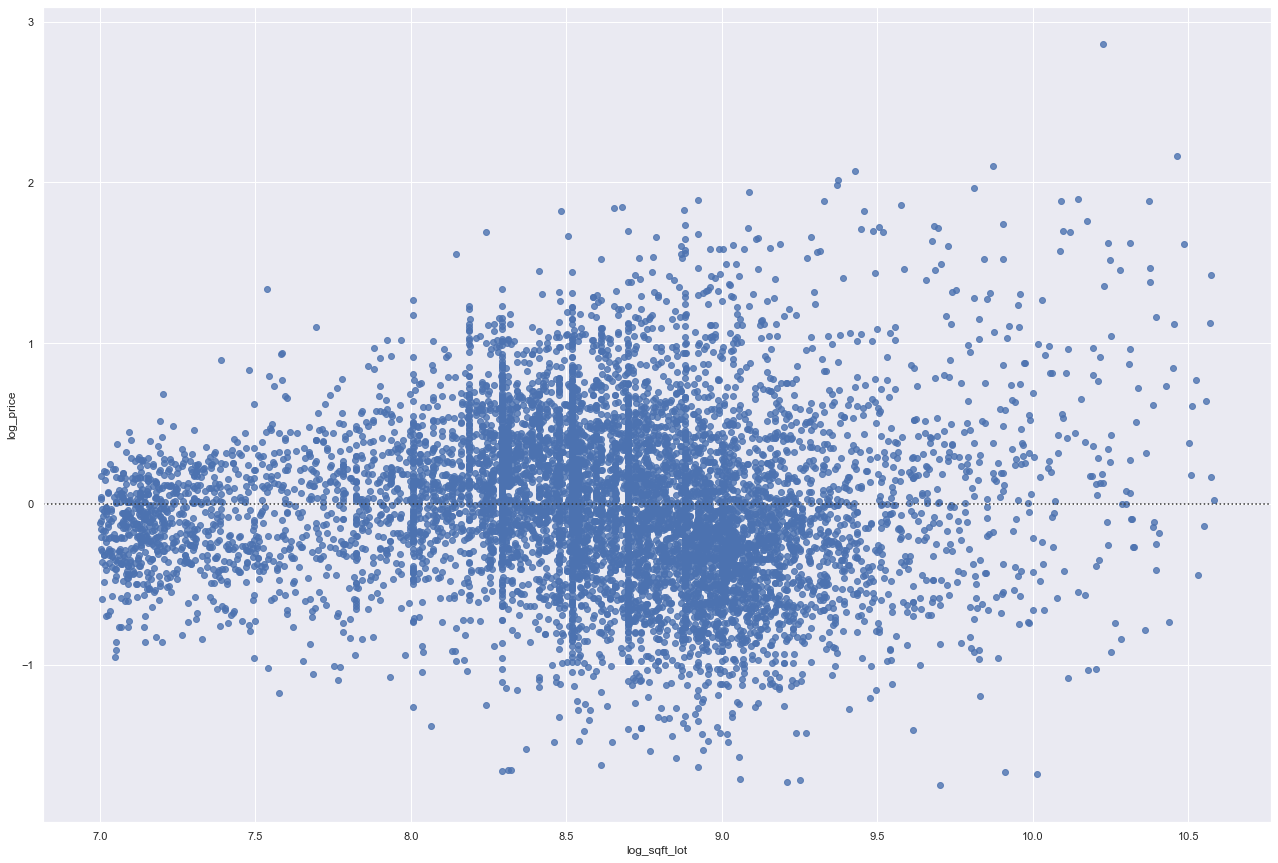

In [128]:
sns.residplot('log_sqft_lot', 'log_price', data=third_model)

In [129]:
third_model

log_sqft_living  log_sqft_lot  log_price          id  wtr_1.0  bed_2  \
0             7.073270      8.639411  12.309982  7129300520        0      0   
1             7.851661      8.887653  13.195614  6414100192        0      0   
3             7.580700      8.517193  13.311329  2487200875        0      0   
7             6.966024      9.181015  12.583995  2008000270        0      0   
8             7.484369      8.918650  12.343658  2414600126        0      0   
...                ...           ...        ...         ...      ...    ...   
21590         8.163371      8.881836  13.825461  7936000429        0      0   
21591         7.177782      7.165493  13.071070  2997800021        0      0   
21592         7.333023      7.030857  12.793859   263000018        0      0   
21593         7.745003      8.667852  12.899220  6600060120        0      0   
21594         6.927558      7.207860  12.904459  1523300141        0      1   

       bed_3  bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  flr_1.5  flr_2.0  \
0          1      0      0      0      0      0      0        0        0   
1          1      0      0      0      0      0      0        0        1   
3          0      1      0      0      0      0      0        0        0   
7          1      0      0      0      0      0      0        0        0   
8          1      0      0      0      0      0      0        0        0   
...      ...    ...    ...    ...    ...    ...    ...      ...      ...   
21590      0      1      0      0      0      0      0        0        1   
21591      1      0      0      0      0      0      0        0        1   
21592      1      0      0      0      0      0      0        0        0   
21593      0      1      0      0      0      0      0        0        1   
21594      0      0      0      0      0      0      0        0        1   

       flr_2.5  flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  zip_98107  \
0            0        0        0          0          0          0          0   
1            0        0        0          0          0          0          0   
3            0        0        0          0          0          0          0   
7            0        0        0          0          0          0          0   
8            0        0        0          0          0          0          0   
...        ...      ...      ...        ...        ...        ...        ...   
21590        0        0        0          0          0          0          0   
21591        0        0        0          0          0          0          0   
21592        0        1        0          1          0          0          0   
21593        0        0        0          0          0          0          0   
21594        0        0        0          0          0          0          0   

       zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  zip_98117  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21590          0          0          0          0          0          0   
21591          0          0          0          0          1          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   

       zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  zip_98133  \
0              0          0          0          0          0          0   
1              0          0          0          1          0          0   
3              0          0          0          0         

In [130]:
X_cols

['log_sqft_living',
 'log_sqft_lot',
 'wtr_1.0',
 'bed_2',
 'bed_3',
 'bed_4',
 'bed_5',
 'bed_6',
 'bed_7',
 'bed_8',
 'bed_9',
 'flr_1.5',
 'flr_2.0',
 'flr_2.5',
 'flr_3.0',
 'flr_3.5',
 'zip_98103',
 'zip_98105',
 'zip_98106',
 'zip_98107',
 'zip_98108',
 'zip_98109',
 'zip_98112',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98136',
 'zip_98144',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98199',
 'age_(20, 40]',
 'age_(40, 60]',
 'age_(60, 80]',
 'age_(80, 100]',
 'age_(100, 120]']

In [131]:
X = third_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = third_model[X_cols].columns
vif

VIF         features
0   526.082172  log_sqft_living
1   494.075422     log_sqft_lot
2     1.042370          wtr_1.0
3    15.288755            bed_2
4    32.883156            bed_3
5    20.223865            bed_4
6     6.163974            bed_5
7     2.312225            bed_6
8     1.212243            bed_7
9     1.116306            bed_8
10    1.078518            bed_9
11    1.762219          flr_1.5
12    2.947636          flr_2.0
13    1.169149          flr_2.5
14    1.972074          flr_3.0
15    1.039409          flr_3.5
16    6.347672        zip_98103
17    3.211323        zip_98105
18    4.098413        zip_98106
19    3.390670        zip_98107
20    2.825058        zip_98108
21    1.986320        zip_98109
22    3.562191        zip_98112
23    6.664792        zip_98115
24    4.099868        zip_98116
25    6.255100        zip_98117
26    5.862051        zip_98118
27    2.653648        zip_98119
28    3.483524        zip_98122
29    5.204393        zip_98125
30    4.417522        zip_98126
31    5.883281        zip_98133
32    3.475381        zip_98136
33    3.996425        zip_98144
34    4.007637        zip_98146
35    1.624522        zip_98148
36    5.894146        zip_98155
37    3.780303        zip_98166
38    3.918162        zip_98168
39    3.801471        zip_98177
40    3.741895        zip_98178
41    2.534505        zip_98188
42    4.019332        zip_98198
43    4.152553        zip_98199
44    1.878905     age_(20, 40]
45    4.073086     age_(40, 60]
46    6.675161     age_(60, 80]
47    4.114798    age_(80, 100]
48    2.769555   age_(100, 120]

In [132]:
second_model

id     price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
0      7129300520  221900.0         1180      5650        0      0      1   
1      6414100192  538000.0         2570      7242        0      0      1   
3      2487200875  604000.0         1960      5000        0      0      0   
7      2008000270  291850.0         1060      9711        0      0      1   
8      2414600126  229500.0         1780      7470        0      0      1   
...           ...       ...          ...       ...      ...    ...    ...   
21591  2997800021  475000.0         1310      1294        0      0      1   
21592   263000018  360000.0         1530      1131        0      0      1   
21593  6600060120  400000.0         2310      5813        0      0      0   
21594  1523300141  402101.0         1020      1350        0      1      0   
21596  1523300157  325000.0         1020      1076        0      1      0   

       bed_4  bed_5  bed_6  bed_7  bed_8  bed_9  flr_1.5  flr_2.0  flr_2.5  \
0          0      0      0      0      0      0        0        0        0   
1          0      0      0      0      0      0        0        1        0   
3          1      0      0      0      0      0        0        0        0   
7          0      0      0      0      0      0        0        0        0   
8          0      0      0      0      0      0        0        0        0   
...      ...    ...    ...    ...    ...    ...      ...      ...      ...   
21591      0      0      0      0      0      0        0        1        0   
21592      0      0      0      0      0      0        0        0        0   
21593      1      0      0      0      0      0        0        1        0   
21594      0      0      0      0      0      0        0        1        0   
21596      0      0      0      0      0      0        0        1        0   

       flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  zip_98107  \
0            0        0          0          0          0          0   
1            0        0          0          0          0          0   
3            0        0          0          0          0          0   
7            0        0          0          0          0          0   
8            0        0          0          0          0          0   
...        ...      ...        ...        ...        ...        ...   
21591        0        0          0          0          0          0   
21592        1        0          1          0          0          0   
21593        0        0          0          0          0          0   
21594        0        0          0          0          0          0   
21596        0        0          0          0          0          0   

       zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  zip_98117  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21591          0          0          0          0          1          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   
21596          0          0          0          0          0          0   

       zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  zip_98133  \
0              0          0          0          0          0          0   
1              0          0          0          1          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0        

In [133]:
second_model.describe()

id         price   sqft_living      sqft_lot      wtr_1.0  \
count  8.853000e+03  8.853000e+03   8853.000000   8853.000000  8853.000000   
mean   4.605709e+09  5.338992e+05   1792.088445   6280.103242     0.006664   
std    2.843530e+09  3.354335e+05    786.465439   4311.252953     0.081368   
min    1.200019e+06  7.800000e+04    370.000000    520.000000     0.000000   
25%    2.172001e+09  3.375000e+05   1240.000000   3880.000000     0.000000   
50%    4.023500e+09  4.529500e+05   1640.000000   5525.000000     0.000000   
75%    7.234600e+09  6.300000e+05   2190.000000   7800.000000     0.000000   
max    9.900000e+09  7.700000e+06  12050.000000  39446.000000     1.000000   

             bed_2        bed_3        bed_4        bed_5        bed_6  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.225912     0.442110     0.236869     0.060883     0.014684   
std       0.418205     0.496665     0.425185     0.239130     0.120293   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             bed_7        bed_8        bed_9      flr_1.5      flr_2.0  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.002259     0.000904     0.000678     0.156444     0.239354   
std       0.047479     0.030049     0.026026     0.363296     0.426713   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           flr_2.5      flr_3.0      flr_3.5    zip_98103    zip_98105  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.011296     0.063029     0.000791     0.067661     0.025754   
std       0.105685     0.243030     0.028110     0.251177     0.158409   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         zip_98106    zip_98107    zip_98108    zip_98109    zip_98112  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.037050     0.029820     0.020897     0.012312     0.030272   
std       0.188894     0.170101     0.143047     0.110281     0.171345   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         zip_98115    zip_98116    zip_98117    zip_98118    zip_98119  \
count  8853.000000  8853.000000  8853.000000  8853.000000  8853.000000   
mean      0.065063     0.037163     0.061900     0.056139     0.020784   
std       0.246650     0.189171     0.240987     0.230203     0.142668   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000

In [134]:
second_model.sort_values(by='sqft_lot', ascending=False).head(200)

id      price  sqft_living  sqft_lot  wtr_1.0  bed_2  bed_3  \
6362   4017110020   445800.0         2070     39446        0      0      0   
15498  4030100005  1800000.0         4320     39094        1      0      0   
17320  2105200010   515000.0         2030     39049        0      0      0   
4422   7781600100  1340000.0         2730     38869        0      0      1   
15673  3585900190   825000.0         3400     38400        0      0      1   
3328   2011400405   380000.0         1320     38125        0      0      0   
6373   9169600275   280000.0         2280     37500        0      1      0   
7865   1454100650   942000.0         3160     37200        0      0      0   
15713  6116500290   799950.0         3040     36721        0      0      0   
8410   4027700594   520000.0         2310     36665        0      0      1   
14971  8665900168   635000.0         4260     36360        0      0      0   
16600  7935000280  2200000.0         5210     35765        0      0      0   
19002  2303900100  3800000.0         5510     35000        0      0      1   
6471   7936500190  1340000.0         2130     34689        1      0      0   
6505   1024039049  1020000.0         2920     34527        0      0      1   
794    1623049062   210000.0          750     34133        0      1      0   
8492   4019300155   911100.0         3330     33826        0      0      0   
15501  3361402066   365000.0         3080     32997        0      0      0   
16708   798000630   340000.0         2020     32710        0      0      0   
14216  1447600410   290000.0         1480     32700        0      0      1   
19342  3585300194  1400000.0         4140     32700        0      0      0   
13249  2011400021   392000.0         3740     32481        0      0      0   
20748  9536600810   380000.0         1984     32400        0      0      0   
9488   3586500770   808000.0         2590     32380        0      0      1   
17298  3585901025  1740000.0         4310     32093        0      0      1   
3154   1827200265  1900000.0         3690     32044        1      1      0   
4186   2303900090  2880000.0         5760     32033        0      0      0   
9036   3586501075   600000.0         2840     31720        0      0      0   
7941    257000037   200000.0         2120     31564        0      0      1   
3114   4019300195   900000.0         2990     30869        0      0      1   
14483  3585300410   729000.0         1770     30689        0      0      1   
4410   8108600464   335000.0         2150     30476        0      0      1   
18682  1623049241   335000.0         2390     30409        0      0      1   
20330  5379805260   400200.0         2260     30250        0      0      0   
19316   123039176   399888.0         2370     30200        0      0      0   
18942   327000165  1150000.0         2330     30122        0      0      0   
14172  1333300145  2230000.0         4200     30120        0      0      1   
6310   4027701253   470000.0         1990     30083        0      0      0   
7773   3023049186   575000.0         2500     30056        0      0      1   
2454   7632400400  1050000.0         3190     29982        0      0      1   
17876  9289900065   440000.0         2100     29735        0      0      1   
10775  6411600370   475000.0         2870     29699        0      0      0   
5868   9141100255   438000.0         1950     29347        0      1      0   
8206   2144800615   190000.0          930     29258        0      0      0   
4214   1025039086  1880000.0         3280     29111        1      0      1   
12732  7247000035   210000.0         2180     28710        0      0      0   
1083   6114600030   675000.0         2690     28300        0      0      0   
11619  3585900045  1250000.0         2960     28300        0      0      0   
8789   2613200025   175000.0         1330     28270        0      1      0   
5099   9289100170   569950.0         2510     28185        0      0      0   
17665  3585901085  2010000.0         

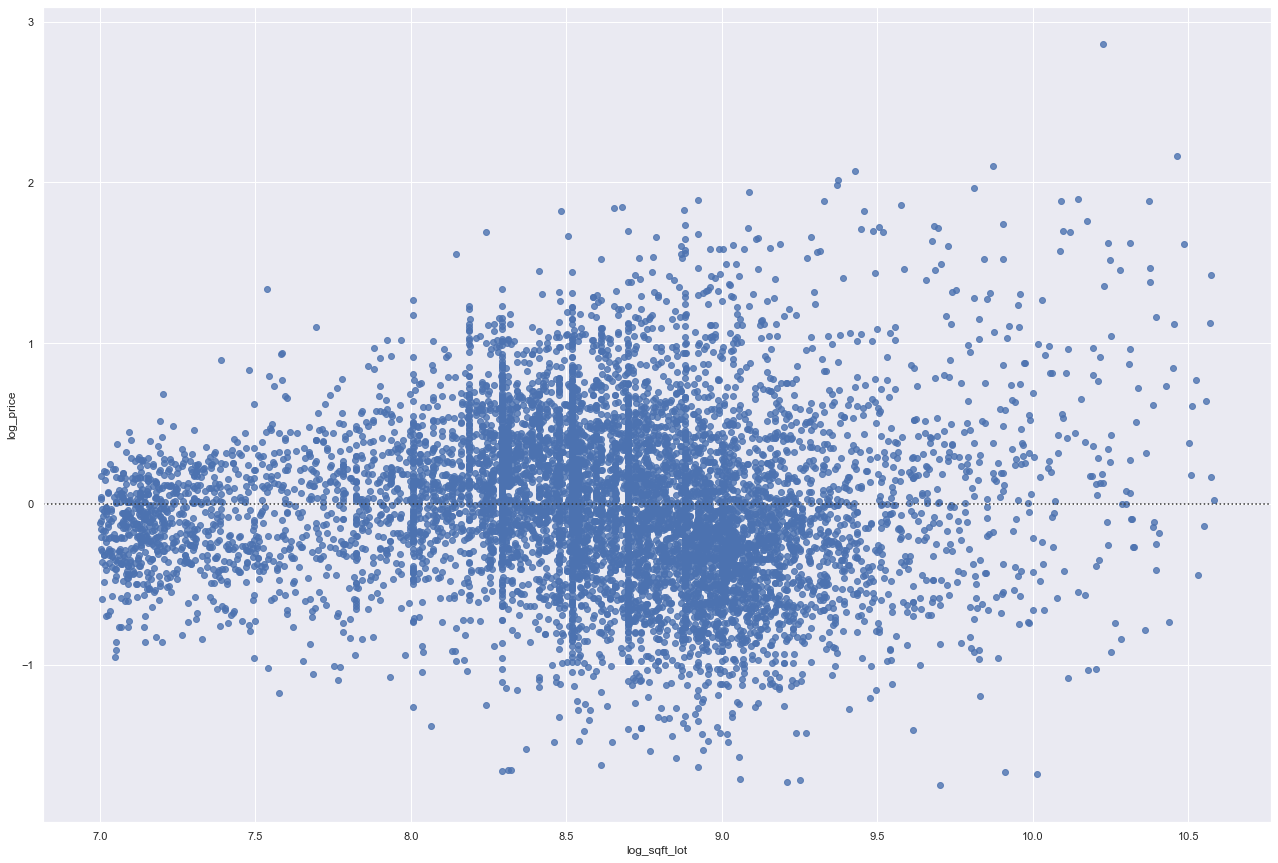

In [135]:
sns.residplot('log_sqft_lot', 'log_price', data=third_model)

(array([4.300e+01, 2.550e+02, 1.350e+03, 3.078e+03, 2.628e+03, 8.650e+02,
        2.820e+02, 6.900e+01, 7.000e+00, 1.000e+00]),
 array([11.26446411, 11.72369078, 12.18291746, 12.64214414, 13.10137082,
        13.5605975 , 14.01982417, 14.47905085, 14.93827753, 15.39750421,
        15.85673089]),
 <a list of 10 Patch objects>)

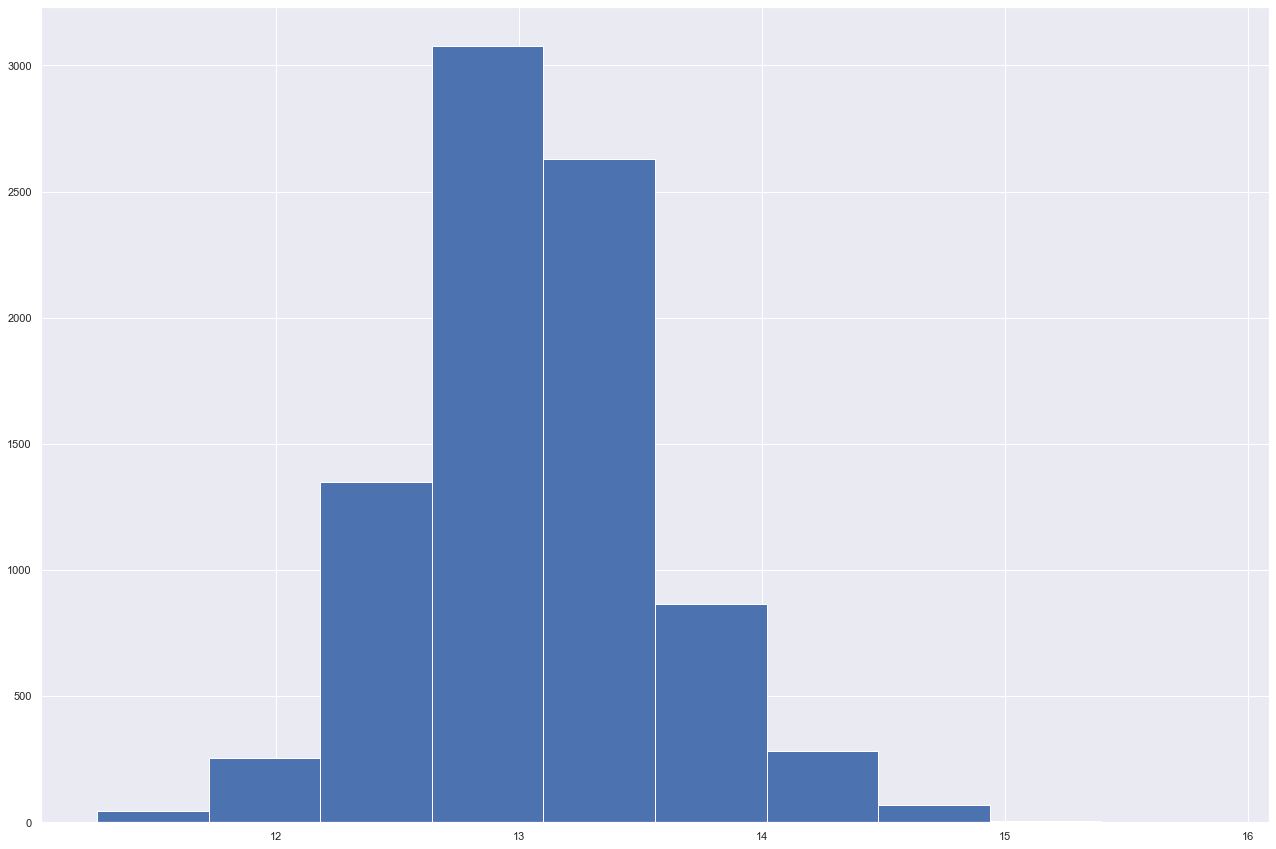

In [136]:
plt.hist('log_price', data=third_model)

In [137]:
third_model.sort_values(by='log_price', ascending=False).head(200)

log_sqft_living  log_sqft_lot  log_price          id  wtr_1.0  bed_2  \
7245          9.396820     10.225571  15.856731  6762700020        0      0   
19002         8.614320     10.463103  15.150512  2303900100        0      0   
6502          8.608860      9.873080  15.110238  4217402115        1      0   
2862          8.521185      9.427949  15.096444  4114601570        1      0   
10435         8.357024      9.372884  15.039286  1118000320        0      0   
18462         8.950273      9.371609  15.009433  1346300150        0      0   
7900          8.867850      9.809177  14.978661  1068000375        0      0   
7184          8.733916      9.088850  14.978661  7159200005        0      0   
15244         8.330864      8.922658  14.937188  1732800780        0      0   
11963         8.431635      9.329456  14.914123  1118000340        0      0   
20138         8.375630      8.652074  14.897316  1176001310        0      0   
18541         8.266164     10.145257  14.897316  6613000930        1      0   
20519         8.405144      8.679992  14.897316  1370800515        0      0   
18314         8.428362     10.089345  14.887094  5317100750        0      0   
7926          8.429454      8.484257  14.880221  7159200040        0      0   
14017         8.584852      9.574983  14.876767  5316101075        0      0   
3809          8.662159      8.878079  14.876767  1118000301        0      0   
4186          8.658693     10.374522  14.873301  2303900090        0      0   
11608         8.431635      9.456653  14.845130  1069000070        0      0   
18394         8.619750      8.881836  14.782494  2397101606        0      0   
7425          8.095599      8.242756  14.763300  5316100780        0      0   
11213         8.575462     10.173934  14.755518  6613000935        1      0   
13243         8.340456      9.083075  14.751604  1954700410        0      0   
1431          8.218787      9.903488  14.747675  9471200370        0      0   
3381          8.596004      9.505321  14.747675  1118001408        0      0   
7645          8.377931      8.699515  14.747675  9185700485        0      0   
2038          8.525161      9.683340  14.743730  9471200200        0      0   
7499          8.283999      9.694247  14.731801  9471200265        0      0   
4028          8.634087      9.447150  14.731801  5700003585        0      0   
4807          8.826147      8.922658  14.723769  9831200500        0      0   
18212         8.375630      8.506537  14.723769  1176001293        0      0   
5697          8.762490      9.486456  14.719729  1118002000        0      0   
1030          8.354674      8.787526  14.711599  5700004028        0      0   
3731          8.461680      9.516795  14.711599  1118000110        0      0   
13398         8.972083     10.096172  14.699278  2426039123        0      0   
14499         8.608860      9.287301  14.690979  6169900790        0      0   
6189          8.675905      8.881836  14.690979  9185700440        0      0   
5612          8.134468      9.114710  14.690979  3880900010        0      0   
1943          8.316300     10.119606  14.690979  3398800055        0      0   
312           8.202482      9.110520  14.682611  1860600135        0      0   
16930         8.095599      8.867850  14.648420  3880900170        0      0   
15539         8.286521      9.187890  14.648420  1732801150        0      0   
11390         8.321178      9.675897  14.648420  3426049284        1      0   
13007         8.122668      9.036225  14.648420  1118001201        0      0   
19742         8.266164      8.146709  14.626441  9831200159        0      0   
13058         8.137396      9.071078  14.626441  1118001215        0      0   
1674          8.398410      9.002701  14.626441  5700003985        0      0   
518           8.468003      8.991687  14.626441  4386700135        0      0   
6777          8.304000      8.881836  14.626441  5316100980        0      0   
17274         8.546752      8.961879  14.626441  53161009

In [138]:
fourth_model = third_model[third_model['log_price'] < 15]

In [139]:
X_cols = [c for c in fourth_model.columns.to_list() if c not in ['log_price', 'id']]

In [140]:
X = fourth_model[X_cols]
y = fourth_model['log_price']

In [141]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.summary()

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     656.8
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:38:01   Log-Likelihood:                 381.31
No. Observations:                8572   AIC:                            -662.6
Df Residuals:                    8522   BIC:                            -309.8
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.5455      0.075    101.017      0.000       7.399       7.692
log_sqft_living     0.6527      0.010     66.823      0.000       0.634       0.672
log_sqft_lot        0.1362      0.007     19.484      0.000       0.122       0.150
wtr_1.0             0.6860      0.032     21.635      0.000       0.624       0.748
bed_2              -0.0286      0.021     -1.343      0.179      -0.070       0.013
bed_3              -0.0720      0.022     -3.312      0.001      -0.115      -0.029
bed_4              -0.0860      0.023     -3.769      0.000      -0.131      -0.041
bed_5              -0.1373      0.025     -5.516      0.000      -0.186      -0.088
bed_6              -0.1755      0.031     -5.638      0.000      -0.236      -0.114
bed_7              -0.2882      0.057     -5.036      0.000      -0.400      -0.176
bed_8              -0.3451      0.091     -3.788      0.000      -0.524      -0.167
bed_9              -0.4759      0.098     -4.834      0.000      -0.669      -0.283
flr_1.5             0.0108      0.008      1.306      0.192      -0.005       0.027
flr_2.0             0.0949      0.009     10.602      0.000       0.077       0.113
flr_2.5             0.1456      0.025      5.749      0.000       0.096       0.195
flr_3.0             0.0804      0.016      5.057      0.000       0.049       0.112
flr_3.5             0.0699      0.117      0.598      0.550      -0.159       0.299
zip_98103          -0.1858      0.026     -7.091      0.000      -0.237      -0.134
zip_98105          -0.0453      0.029     -1.569      0.117      -0.102       0.011
zip_98106          -0.7420      0.028    -26.478      0.000      -0.797      -0.687
zip_98107          -0.1426      0.028     -5.033      0.000      -0.198      -0.087
zip_98108          -0.7249      0.030    -24.229      0.000      -0.783      -0.666
zip_98109           0.0421      0.033      1.266      0.206      -0.023       0.107
zip_98112           0.0620      0.028      2.202      0.028       0.007       0.117
zip_98115          -0.2322      0.026     -8.809      0.000      -0.284      -0.181
zip_98116          -0.2443      0.028     -8.832      0.000      -0.299      -0.190
zip_98117          -0.2230      0.026     -8.459      0.000      -0.275      -0.171
zip_98118          -0.6148      0.027    -23.038      0.000      -0.667      -0.562
zip_98119           0.0155      0.030      0.520      0.603      -0.043       0.074
zip_98122          -0.1836      0.028     -6.563      0.000      -0.238      -0.129
zip_98125          -0.5150      0.028    -18.647      0.000      -0.569      -0.461
zip_98126          -0.4960      0.028    -18.007      0.000      -0.550      -0.442
zip_98133          -0.6206      0.027    -22.820      0.000      -0.674      -0.567
zip_98136          -0.3398      0.029    -11.870      0.000

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [143]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [144]:
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error V1: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Root Mean Squared Error V2: {mean_squared_error(y_test, y_test_pred, squared=False)}")

Training Scores:
R2: 0.7878031655951019
Mean Absolute Error: 0.17629228180048134
---
Testing Scores:
R2: 0.7907420240166314
Mean Absolute Error: 0.17492505237335415
Root Mean Squared Error V1: 0.23139281796514777
Root Mean Squared Error V2: 0.23139281796514777


In [145]:
X_test_scaled.shape

(2143, 49)

In [146]:
y_test_pred.shape

(2143,)

In [147]:
X = fourth_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = fourth_model[X_cols].columns
vif

VIF         features
0   526.064929  log_sqft_living
1   494.601221     log_sqft_lot
2     1.042602          wtr_1.0
3    15.295095            bed_2
4    32.877664            bed_3
5    20.224134            bed_4
6     6.167434            bed_5
7     2.287444            bed_6
8     1.212471            bed_7
9     1.078061            bed_8
10    1.078785            bed_9
11    1.761906          flr_1.5
12    2.946005          flr_2.0
13    1.164272          flr_2.5
14    1.973430          flr_3.0
15    1.014546          flr_3.5
16    6.414935        zip_98103
17    3.228554        zip_98105
18    4.134367        zip_98106
19    3.419241        zip_98107
20    2.846975        zip_98108
21    1.998693        zip_98109
22    3.571520        zip_98112
23    6.731035        zip_98115
24    4.137031        zip_98116
25    6.317410        zip_98117
26    5.921145        zip_98118
27    2.675168        zip_98119
28    3.516352        zip_98122
29    5.252920        zip_98125
30    4.457691        zip_98126
31    5.939058        zip_98133
32    3.505188        zip_98136
33    4.021856        zip_98144
34    4.042329        zip_98146
35    1.631402        zip_98148
36    5.949019        zip_98155
37    3.812867        zip_98166
38    3.950406        zip_98168
39    3.818757        zip_98177
40    3.773534        zip_98178
41    2.551671        zip_98188
42    4.052365        zip_98198
43    4.190972        zip_98199
44    1.881215     age_(20, 40]
45    4.080482     age_(40, 60]
46    6.685360     age_(60, 80]
47    4.123061    age_(80, 100]
48    2.769348   age_(100, 120]

In [148]:
pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')[0].sort_values()

zip_98168         -0.185912
zip_98198         -0.172583
zip_98178         -0.159532
zip_98155         -0.144530
zip_98146         -0.144015
zip_98118         -0.142198
zip_98133         -0.135189
zip_98106         -0.134773
zip_98188         -0.128053
zip_98166         -0.125956
zip_98108         -0.109517
zip_98125         -0.106212
zip_98126         -0.093410
zip_98148         -0.080067
zip_98177         -0.071833
zip_98144         -0.064818
zip_98136         -0.058117
zip_98115         -0.056578
zip_98117         -0.051867
bed_4             -0.047097
zip_98116         -0.046544
bed_3             -0.046457
bed_5             -0.042111
zip_98103         -0.041721
zip_98122         -0.031774
bed_6             -0.025738
zip_98107         -0.023920
zip_98199         -0.023203
bed_2             -0.021506
bed_7             -0.015913
age_(40, 60]      -0.015759
age_(20, 40]      -0.010042
bed_9             -0.009392
bed_8             -0.008225
age_(60, 80]      -0.005896
zip_98105         -0

In [149]:
lr.intercept_

13.058570087633772

In [150]:
X_cols

['log_sqft_living',
 'log_sqft_lot',
 'wtr_1.0',
 'bed_2',
 'bed_3',
 'bed_4',
 'bed_5',
 'bed_6',
 'bed_7',
 'bed_8',
 'bed_9',
 'flr_1.5',
 'flr_2.0',
 'flr_2.5',
 'flr_3.0',
 'flr_3.5',
 'zip_98103',
 'zip_98105',
 'zip_98106',
 'zip_98107',
 'zip_98108',
 'zip_98109',
 'zip_98112',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98136',
 'zip_98144',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98199',
 'age_(20, 40]',
 'age_(40, 60]',
 'age_(60, 80]',
 'age_(80, 100]',
 'age_(100, 120]']

In [151]:
fifth_model = fourth_model.drop(columns=['bed_2',
 'bed_3',
 'bed_4',
 'bed_5',
 'bed_6',
 'bed_7',
 'bed_8',
 'bed_9'])

In [152]:
fifth_model

log_sqft_living  log_sqft_lot  log_price          id  wtr_1.0  flr_1.5  \
0             7.073270      8.639411  12.309982  7129300520        0        0   
1             7.851661      8.887653  13.195614  6414100192        0        0   
3             7.580700      8.517193  13.311329  2487200875        0        0   
7             6.966024      9.181015  12.583995  2008000270        0        0   
8             7.484369      8.918650  12.343658  2414600126        0        0   
...                ...           ...        ...         ...      ...      ...   
21590         8.163371      8.881836  13.825461  7936000429        0        0   
21591         7.177782      7.165493  13.071070  2997800021        0        0   
21592         7.333023      7.030857  12.793859   263000018        0        0   
21593         7.745003      8.667852  12.899220  6600060120        0        0   
21594         6.927558      7.207860  12.904459  1523300141        0        0   

       flr_2.0  flr_2.5  flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  \
0            0        0        0        0          0          0          0   
1            1        0        0        0          0          0          0   
3            0        0        0        0          0          0          0   
7            0        0        0        0          0          0          0   
8            0        0        0        0          0          0          0   
...        ...      ...      ...      ...        ...        ...        ...   
21590        1        0        0        0          0          0          0   
21591        1        0        0        0          0          0          0   
21592        0        0        1        0          1          0          0   
21593        1        0        0        0          0          0          0   
21594        1        0        0        0          0          0          0   

       zip_98107  zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21590          0          0          0          0          0          0   
21591          0          0          0          0          0          1   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   

       zip_98117  zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  \
0              0          0          0          0          0          0   
1              0          0          0          0          1          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21590          0          0          0          0          0          0   
21591          0          0          0          0          0          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   

       zip_98133  zip_98136  zip_98144  zip_98146  zip_98148  zip_98155  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          1          0          0          0          

In [153]:
X_cols = [c for c in fifth_model.columns.to_list() if c not in ['id','log_price']]

In [154]:
X = fifth_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = fifth_model[X_cols].columns
vif

VIF         features
0   402.522522  log_sqft_living
1   466.008039     log_sqft_lot
2     1.040896          wtr_1.0
3     1.664338          flr_1.5
4     2.926958          flr_2.0
5     1.143526          flr_2.5
6     1.953209          flr_3.0
7     1.014195          flr_3.5
8     6.213703        zip_98103
9     3.171887        zip_98105
10    4.049152        zip_98106
11    3.307846        zip_98107
12    2.796917        zip_98108
13    1.960363        zip_98109
14    3.493438        zip_98112
15    6.574389        zip_98115
16    4.030676        zip_98116
17    6.134838        zip_98117
18    5.784153        zip_98118
19    2.608533        zip_98119
20    3.415637        zip_98122
21    5.166755        zip_98125
22    4.332238        zip_98126
23    5.826778        zip_98133
24    3.419481        zip_98136
25    3.916451        zip_98144
26    3.985077        zip_98146
27    1.618266        zip_98148
28    5.873452        zip_98155
29    3.776779        zip_98166
30    3.895288        zip_98168
31    3.773766        zip_98177
32    3.725648        zip_98178
33    2.529139        zip_98188
34    3.986124        zip_98198
35    4.092983        zip_98199
36    1.851539     age_(20, 40]
37    3.955193     age_(40, 60]
38    6.637207     age_(60, 80]
39    4.106724    age_(80, 100]
40    2.758771   age_(100, 120]

In [155]:
X = fifth_model[X_cols]
y = fifth_model['log_price']

In [156]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.summary()

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     771.9
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:38:03   Log-Likelihood:                 321.16
No. Observations:                8572   AIC:                            -558.3
Df Residuals:                    8530   BIC:                            -262.0
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.8445      0.064    122.632      0.000       7.719       7.970
log_sqft_living     0.6028      0.008     75.369      0.000       0.587       0.619
log_sqft_lot        0.1371      0.007     19.590      0.000       0.123       0.151
wtr_1.0             0.7097      0.032     22.310      0.000       0.647       0.772
flr_1.5            -0.0003      0.008     -0.035      0.972      -0.016       0.016
flr_2.0             0.0916      0.009     10.186      0.000       0.074       0.109
flr_2.5             0.1234      0.025      4.876      0.000       0.074       0.173
flr_3.0             0.0766      0.016      4.802      0.000       0.045       0.108
flr_3.5             0.0691      0.118      0.587      0.557      -0.162       0.300
zip_98103          -0.1863      0.026     -7.070      0.000      -0.238      -0.135
zip_98105          -0.0535      0.029     -1.844      0.065      -0.110       0.003
zip_98106          -0.7514      0.028    -26.683      0.000      -0.807      -0.696
zip_98107          -0.1446      0.028     -5.074      0.000      -0.200      -0.089
zip_98108          -0.7300      0.030    -24.268      0.000      -0.789      -0.671
zip_98109           0.0470      0.033      1.403      0.161      -0.019       0.113
zip_98112           0.0672      0.028      2.373      0.018       0.012       0.123
zip_98115          -0.2317      0.027     -8.742      0.000      -0.284      -0.180
zip_98116          -0.2401      0.028     -8.630      0.000      -0.295      -0.186
zip_98117          -0.2226      0.027     -8.395      0.000      -0.275      -0.171
zip_98118          -0.6195      0.027    -23.089      0.000      -0.672      -0.567
zip_98119           0.0178      0.030      0.594      0.553      -0.041       0.077
zip_98122          -0.1848      0.028     -6.570      0.000      -0.240      -0.130
zip_98125          -0.5191      0.028    -18.695      0.000      -0.574      -0.465
zip_98126          -0.4952      0.028    -17.874      0.000      -0.550      -0.441
zip_98133          -0.6258      0.027    -22.885      0.000      -0.679      -0.572
zip_98136          -0.3356      0.029    -11.654      0.000      -0.392      -0.279
zip_98144          -0.3433      0.028    -12.395      0.000      -0.398      -0.289
zip_98146          -0.8297      0.029    -28.629      0.000      -0.887      -0.773
zip_98148          -0.9912      0.040    -24.535      0.000      -1.070      -0.912
zip_98155          -0.6755      0.028    -24.162      0.000      -0.730      -0.621
zip_98166          -0.7854      0.030    -26.377      0.000      -0.844      -0.727
zip_98168          -1.0954      0.030    -37.001      0.000      -1.153      -1.037
zip_98177          -0.4203      0.029    -14.274      0.000      -0.478      -0.363
zip_98178          -0.9664      0.029    -33.134      0.000

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [158]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [159]:
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error V1: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Root Mean Squared Error V2: {mean_squared_error(y_test, y_test_pred, squared=False)}")

Training Scores:
R2: 0.787336192349256
Mean Absolute Error: 0.1759423300085455
---
Testing Scores:
R2: 0.782420355062368
Mean Absolute Error: 0.17774066159976482
Root Mean Squared Error V1: 0.2341920772588171
Root Mean Squared Error V2: 0.2341920772588171


In [160]:
pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')[0].sort_values()

zip_98168         -0.192446
zip_98198         -0.178039
zip_98178         -0.162537
zip_98146         -0.150023
zip_98155         -0.148130
zip_98118         -0.144709
zip_98106         -0.140946
zip_98133         -0.139181
zip_98188         -0.132182
zip_98166         -0.126963
zip_98125         -0.108334
zip_98108         -0.104482
zip_98126         -0.096362
zip_98148         -0.080090
zip_98177         -0.071768
zip_98144         -0.066192
zip_98115         -0.056300
zip_98117         -0.054990
zip_98136         -0.054045
zip_98116         -0.046582
zip_98103         -0.045485
zip_98122         -0.033547
zip_98107         -0.025807
age_(40, 60]      -0.024208
zip_98199         -0.022891
age_(60, 80]      -0.012915
age_(20, 40]      -0.010631
zip_98105         -0.010542
age_(100, 120]    -0.001802
flr_1.5            0.001057
flr_3.5            0.001508
zip_98109          0.005059
zip_98119          0.005302
age_(80, 100]      0.009922
zip_98112          0.010527
flr_2.5            0

In [161]:
X = fifth_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = fifth_model[X_cols].columns
vif

VIF         features
0   402.522522  log_sqft_living
1   466.008039     log_sqft_lot
2     1.040896          wtr_1.0
3     1.664338          flr_1.5
4     2.926958          flr_2.0
5     1.143526          flr_2.5
6     1.953209          flr_3.0
7     1.014195          flr_3.5
8     6.213703        zip_98103
9     3.171887        zip_98105
10    4.049152        zip_98106
11    3.307846        zip_98107
12    2.796917        zip_98108
13    1.960363        zip_98109
14    3.493438        zip_98112
15    6.574389        zip_98115
16    4.030676        zip_98116
17    6.134838        zip_98117
18    5.784153        zip_98118
19    2.608533        zip_98119
20    3.415637        zip_98122
21    5.166755        zip_98125
22    4.332238        zip_98126
23    5.826778        zip_98133
24    3.419481        zip_98136
25    3.916451        zip_98144
26    3.985077        zip_98146
27    1.618266        zip_98148
28    5.873452        zip_98155
29    3.776779        zip_98166
30    3.895288        zip_98168
31    3.773766        zip_98177
32    3.725648        zip_98178
33    2.529139        zip_98188
34    3.986124        zip_98198
35    4.092983        zip_98199
36    1.851539     age_(20, 40]
37    3.955193     age_(40, 60]
38    6.637207     age_(60, 80]
39    4.106724    age_(80, 100]
40    2.758771   age_(100, 120]

In [162]:
#checking correlations between variables
pd.DataFrame(fifth_model.corr().abs().stack().sort_values(0, ascending=False)).head(50)

0
age_(100, 120]  age_(100, 120]   1.000000
zip_98118       zip_98118        1.000000
zip_98125       zip_98125        1.000000
zip_98126       zip_98126        1.000000
zip_98133       zip_98133        1.000000
zip_98136       zip_98136        1.000000
zip_98144       zip_98144        1.000000
zip_98146       zip_98146        1.000000
zip_98148       zip_98148        1.000000
zip_98155       zip_98155        1.000000
zip_98166       zip_98166        1.000000
zip_98168       zip_98168        1.000000
zip_98177       zip_98177        1.000000
zip_98178       zip_98178        1.000000
zip_98188       zip_98188        1.000000
zip_98198       zip_98198        1.000000
zip_98199       zip_98199        1.000000
age_(20, 40]    age_(20, 40]     1.000000
age_(40, 60]    age_(40, 60]     1.000000
zip_98122       zip_98122        1.000000
zip_98117       zip_98117        1.000000
age_(80, 100]   age_(80, 100]    1.000000
zip_98116       zip_98116        1.000000
log_sqft_lot    log_sqft_lot     1.000000
log_price       log_price        1.000000
id              id               1.000000
wtr_1.0         wtr_1.0          1.000000
flr_1.5         flr_1.5          1.000000
flr_2.0         flr_2.0          1.000000
flr_2.5         flr_2.5          1.000000
flr_3.0         flr_3.0          1.000000
flr_3.5         flr_3.5          1.000000
zip_98103       zip_98103        1.000000
zip_98105       zip_98105        1.000000
zip_98106       zip_98106        1.000000
zip_98107       zip_98107        1.000000
zip_98108       zip_98108        1.000000
zip_98109       zip_98109        1.000000
zip_98112       zip_98112        1.000000
zip_98115       zip_98115        1.000000
age_(60, 80]    age_(60, 80]     1.000000
zip_98119       zip_98119        1.000000
log_sqft_living log_sqft_living  1.000000
log_price       log_sqft_living  0.660638
log_sqft_living log_price        0.660638
log_sqft_lot    flr_3.0          0.406986
flr_3.0         log_sqft_lot     0.406986
flr_1.5         age_(80, 100]    0.320220
age_(80, 100]   flr_1.5          0.320220
log_sqft_living flr_2.0          0.319032

Text(0.5, 1.0, 'Price by Home Square Footage')

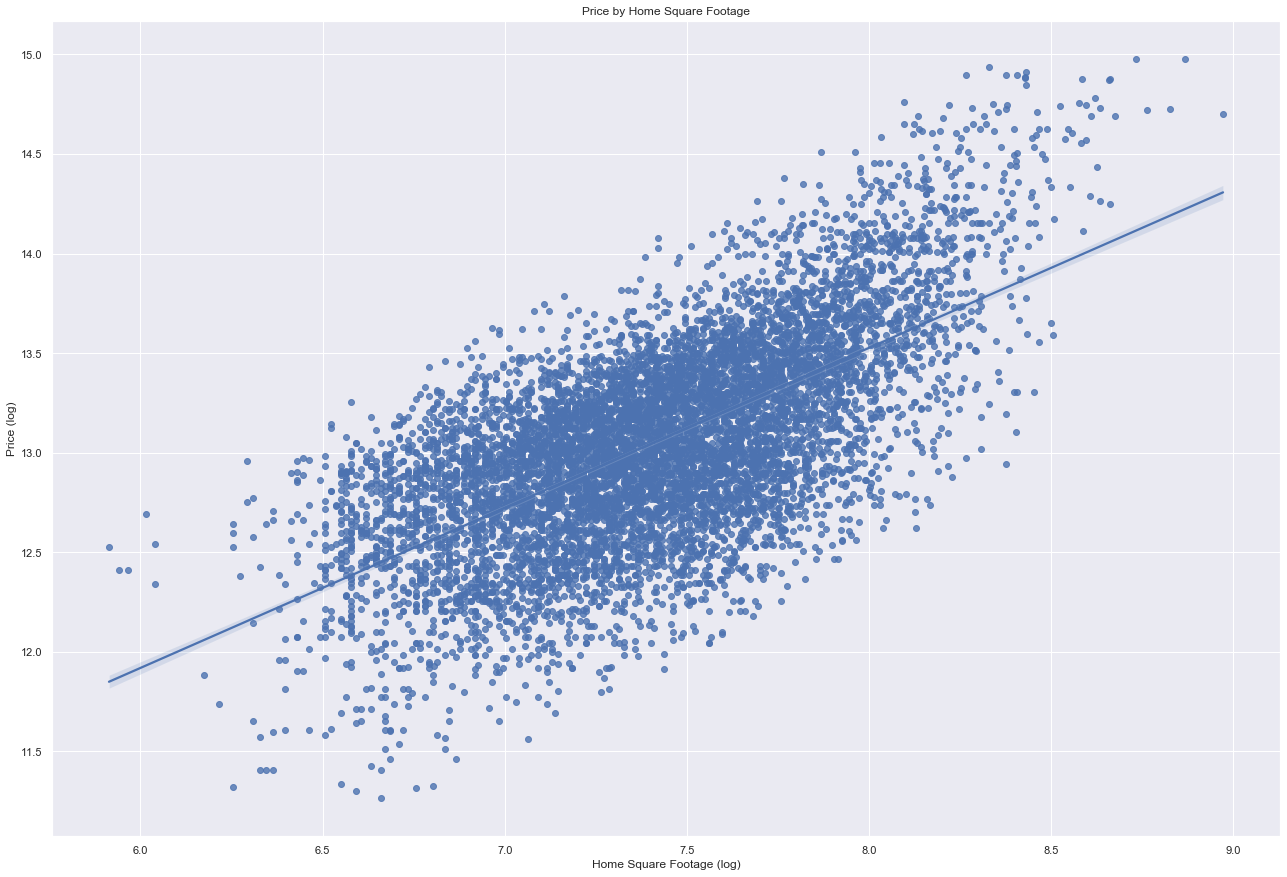

In [163]:
ax = sns.regplot(x="log_sqft_living", y="log_price", data=fifth_model)
plt.xlabel('Home Square Footage (log)')
plt.ylabel('Price (log)')
plt.title('Price by Home Square Footage')

Text(0.5, 1.0, 'Price by Lot Square Footage')

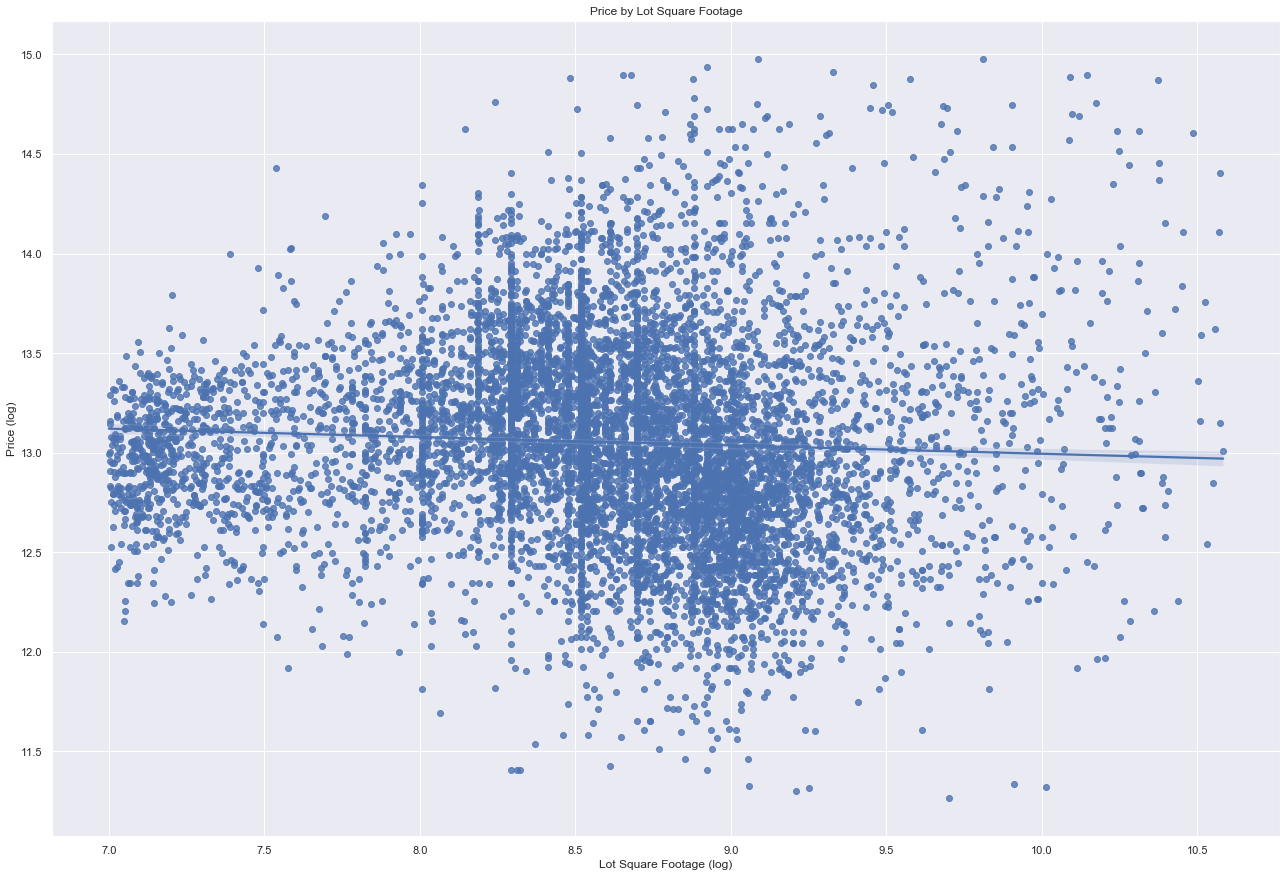

In [164]:
ax = sns.regplot(x="log_sqft_lot", y="log_price", data=fifth_model)
plt.xlabel('Lot Square Footage (log)')
plt.ylabel('Price (log)')
plt.title('Price by Lot Square Footage')

## Sixth Model: Drop `log_sqft_lot`

The VIF for `log_sqft_lot` is very high, so it is difficult to ascertain the effects of the other variables on `log_price`. The visualization also above displays a very small relationship with `log_price`.

In [165]:
sixth_model = fifth_model.drop(columns=['log_sqft_lot'])

In [166]:
sixth_model

log_sqft_living  log_price          id  wtr_1.0  flr_1.5  flr_2.0  \
0             7.073270  12.309982  7129300520        0        0        0   
1             7.851661  13.195614  6414100192        0        0        1   
3             7.580700  13.311329  2487200875        0        0        0   
7             6.966024  12.583995  2008000270        0        0        0   
8             7.484369  12.343658  2414600126        0        0        0   
...                ...        ...         ...      ...      ...      ...   
21590         8.163371  13.825461  7936000429        0        0        1   
21591         7.177782  13.071070  2997800021        0        0        1   
21592         7.333023  12.793859   263000018        0        0        0   
21593         7.745003  12.899220  6600060120        0        0        1   
21594         6.927558  12.904459  1523300141        0        0        1   

       flr_2.5  flr_3.0  flr_3.5  zip_98103  zip_98105  zip_98106  zip_98107  \
0            0        0        0          0          0          0          0   
1            0        0        0          0          0          0          0   
3            0        0        0          0          0          0          0   
7            0        0        0          0          0          0          0   
8            0        0        0          0          0          0          0   
...        ...      ...      ...        ...        ...        ...        ...   
21590        0        0        0          0          0          0          0   
21591        0        0        0          0          0          0          0   
21592        0        1        0          1          0          0          0   
21593        0        0        0          0          0          0          0   
21594        0        0        0          0          0          0          0   

       zip_98108  zip_98109  zip_98112  zip_98115  zip_98116  zip_98117  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21590          0          0          0          0          0          0   
21591          0          0          0          0          1          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   

       zip_98118  zip_98119  zip_98122  zip_98125  zip_98126  zip_98133  \
0              0          0          0          0          0          0   
1              0          0          0          1          0          0   
3              0          0          0          0          0          0   
7              0          0          0          0          0          0   
8              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
21590          0          0          0          0          0          0   
21591          0          0          0          0          0          0   
21592          0          0          0          0          0          0   
21593          0          0          0          0          0          0   
21594          0          0          0          0          0          0   

       zip_98136  zip_98144  zip_98146  zip_98148  zip_98155  zip_98166  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
3              1          0          0          0          0          0   
7              0          0    

In [167]:
X_cols = [c for c in sixth_model.columns.to_list() if c not in ['id','log_price']]

In [168]:
X = sixth_model[X_cols]
y = sixth_model['log_price']

In [169]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.summary()

/Users/jerpagirsky/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     748.0
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:38:05   Log-Likelihood:                 132.55
No. Observations:                8572   AIC:                            -183.1
Df Residuals:                    8531   BIC:                             106.2
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.3805      0.059    141.793      0.000       8.265       8.496
log_sqft_living     0.6733      0.007     92.198      0.000       0.659       0.688
wtr_1.0             0.7922      0.032     24.577      0.000       0.729       0.855
flr_1.5            -0.0145      0.008     -1.752      0.080      -0.031       0.002
flr_2.0             0.0657      0.009      7.227      0.000       0.048       0.084
flr_2.5             0.0957      0.026      3.706      0.000       0.045       0.146
flr_3.0             0.0004      0.016      0.026      0.979      -0.031       0.031
flr_3.5            -0.0106      0.120     -0.088      0.930      -0.246       0.225
zip_98103          -0.1632      0.027     -6.064      0.000      -0.216      -0.110
zip_98105          -0.0258      0.030     -0.872      0.383      -0.084       0.032
zip_98106          -0.6853      0.029    -23.980      0.000      -0.741      -0.629
zip_98107          -0.1310      0.029     -4.499      0.000      -0.188      -0.074
zip_98108          -0.6749      0.031    -22.047      0.000      -0.735      -0.615
zip_98109           0.0532      0.034      1.554      0.120      -0.014       0.120
zip_98112           0.0968      0.029      3.352      0.001       0.040       0.153
zip_98115          -0.1856      0.027     -6.876      0.000      -0.238      -0.133
zip_98116          -0.1963      0.028     -6.923      0.000      -0.252      -0.141
zip_98117          -0.1867      0.027     -6.903      0.000      -0.240      -0.134
zip_98118          -0.5579      0.027    -20.483      0.000      -0.611      -0.505
zip_98119           0.0261      0.031      0.851      0.395      -0.034       0.086
zip_98122          -0.1713      0.029     -5.958      0.000      -0.228      -0.115
zip_98125          -0.4292      0.028    -15.333      0.000      -0.484      -0.374
zip_98126          -0.4415      0.028    -15.666      0.000      -0.497      -0.386
zip_98133          -0.5354      0.028    -19.434      0.000      -0.589      -0.481
zip_98136          -0.2737      0.029     -9.353      0.000      -0.331      -0.216
zip_98144          -0.3204      0.028    -11.328      0.000      -0.376      -0.265
zip_98146          -0.7208      0.029    -24.791      0.000      -0.778      -0.664
zip_98148          -0.8639      0.041    -21.196      0.000      -0.944      -0.784
zip_98155          -0.5517      0.028    -19.818      0.000      -0.606      -0.497
zip_98166          -0.6525      0.030    -22.015      0.000      -0.711      -0.594
zip_98168          -0.9570      0.029    -32.566      0.000      -1.015      -0.899
zip_98177          -0.3119      0.030    -10.550      0.000      -0.370      -0.254
zip_98178          -0.8733      0.029    -29.690      0.000      -0.931      -0.816
zip_98188          -0.8977      0.033    -27.426      0.000

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [171]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [172]:
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Root Mean Squared Error V1: {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Root Mean Squared Error V2: {mean_squared_error(y_test, y_test_pred, squared=False)}")

Training Scores:
R2: 0.7768315675509598
Mean Absolute Error: 0.18081798721207426
---
Testing Scores:
R2: 0.7778351685658723
Mean Absolute Error: 0.18324263775944605
Root Mean Squared Error V1: 0.2402632046917937
Root Mean Squared Error V2: 0.2402632046917937


In [173]:
pd.DataFrame.from_dict(dict(zip(X.columns, lr.coef_)), orient='index')[0].sort_values()

zip_98168         -0.163709
zip_98198         -0.151278
zip_98178         -0.143729
zip_98118         -0.130908
zip_98106         -0.128677
zip_98146         -0.127358
zip_98133         -0.122196
zip_98155         -0.120802
zip_98188         -0.111896
zip_98166         -0.105622
zip_98108         -0.093558
zip_98125         -0.087867
zip_98126         -0.082222
zip_98148         -0.068222
zip_98144         -0.059100
zip_98177         -0.050070
zip_98117         -0.045862
zip_98115         -0.045117
zip_98136         -0.042957
zip_98103         -0.040603
zip_98116         -0.035283
zip_98122         -0.027989
zip_98107         -0.022565
zip_98199         -0.014283
zip_98105         -0.004468
flr_1.5           -0.002800
flr_3.5           -0.001064
flr_3.0            0.000954
zip_98119          0.004194
age_(40, 60]       0.004617
age_(20, 40]       0.006222
zip_98109          0.006943
flr_2.5            0.010435
zip_98112          0.015716
age_(100, 120]     0.023033
flr_2.0            0

In [174]:
lr.intercept_

13.054905257545116

In [175]:
X = sixth_model[X_cols]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = sixth_model[X_cols].columns
vif

VIF         features
0   95.456635  log_sqft_living
1    1.032610          wtr_1.0
2    1.629251          flr_1.5
3    2.819621          flr_2.0
4    1.132715          flr_2.5
5    1.869780          flr_3.0
6    1.013494          flr_3.5
7    5.892120        zip_98103
8    3.058845        zip_98105
9    3.668996        zip_98106
10   3.173594        zip_98107
11   2.621778        zip_98108
12   1.924351        zip_98109
13   3.370477        zip_98112
14   6.143943        zip_98115
15   3.796335        zip_98116
16   5.758853        zip_98117
17   5.278935        zip_98118
18   2.542724        zip_98119
19   3.284265        zip_98122
20   4.625120        zip_98125
21   3.993461        zip_98126
22   5.147265        zip_98133
23   3.167713        zip_98136
24   3.743218        zip_98144
25   3.491782        zip_98146
26   1.501174        zip_98148
27   5.018281        zip_98155
28   3.292075        zip_98166
29   3.285573        zip_98168
30   3.408204        zip_98177
31   3.352881        zip_98178
32   2.234459        zip_98188
33   3.458005        zip_98198
34   3.913540        zip_98199
35   1.755163     age_(20, 40]
36   3.660660     age_(40, 60]
37   5.450606     age_(60, 80]
38   3.617717    age_(80, 100]
39   2.465966   age_(100, 120]

Below are cross validation scores for both $R^{2}$ and negative mean absolute error. These are to help compare and ascertain these values for the model if it is run $n$ times.

$R^{2}$ below.

In [178]:
cv_5_results  = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=5,  scoring='r2'))
cv_10_results = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=10, scoring='r2'))
cv_20_results = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=20, scoring='r2'))

In [182]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

0.9846880168078596
0.9878335089888131
0.81068284561183


Negative mean absolute error below.

In [176]:
cv_5_results  = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=5,  scoring='neg_mean_absolute_error'))
cv_10_results = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=10, scoring='neg_mean_absolute_error'))
cv_20_results = np.mean(cross_val_score(lr, X_test_scaled, y_test_pred, cv=20, scoring='neg_mean_absolute_error'))

In [177]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-0.0011796982514169815
-0.0010465285481934552
-0.004395138692440408


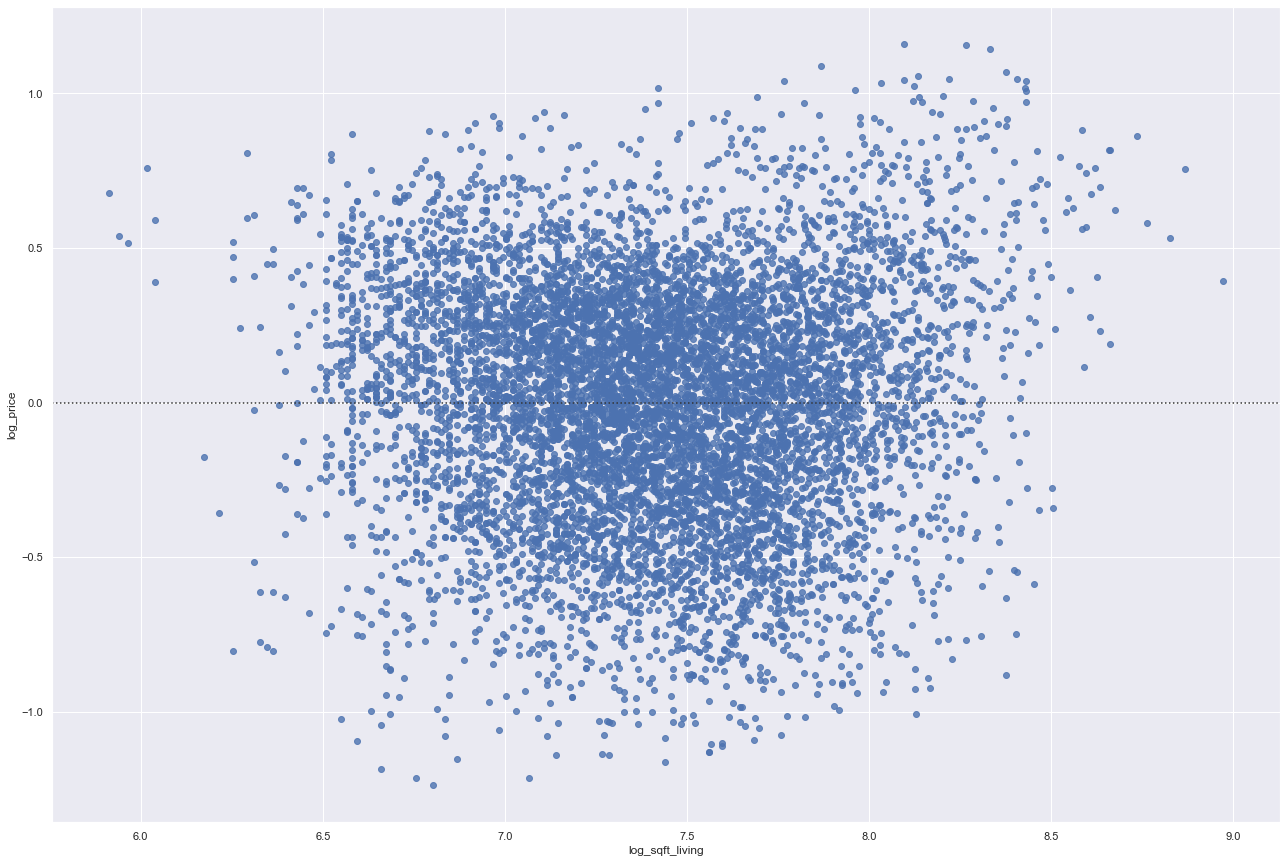

In [180]:
sns.residplot('log_sqft_living', 'log_price', data=sixth_model)

Text(0.5, 1.0, 'Price by Home Square Footage')

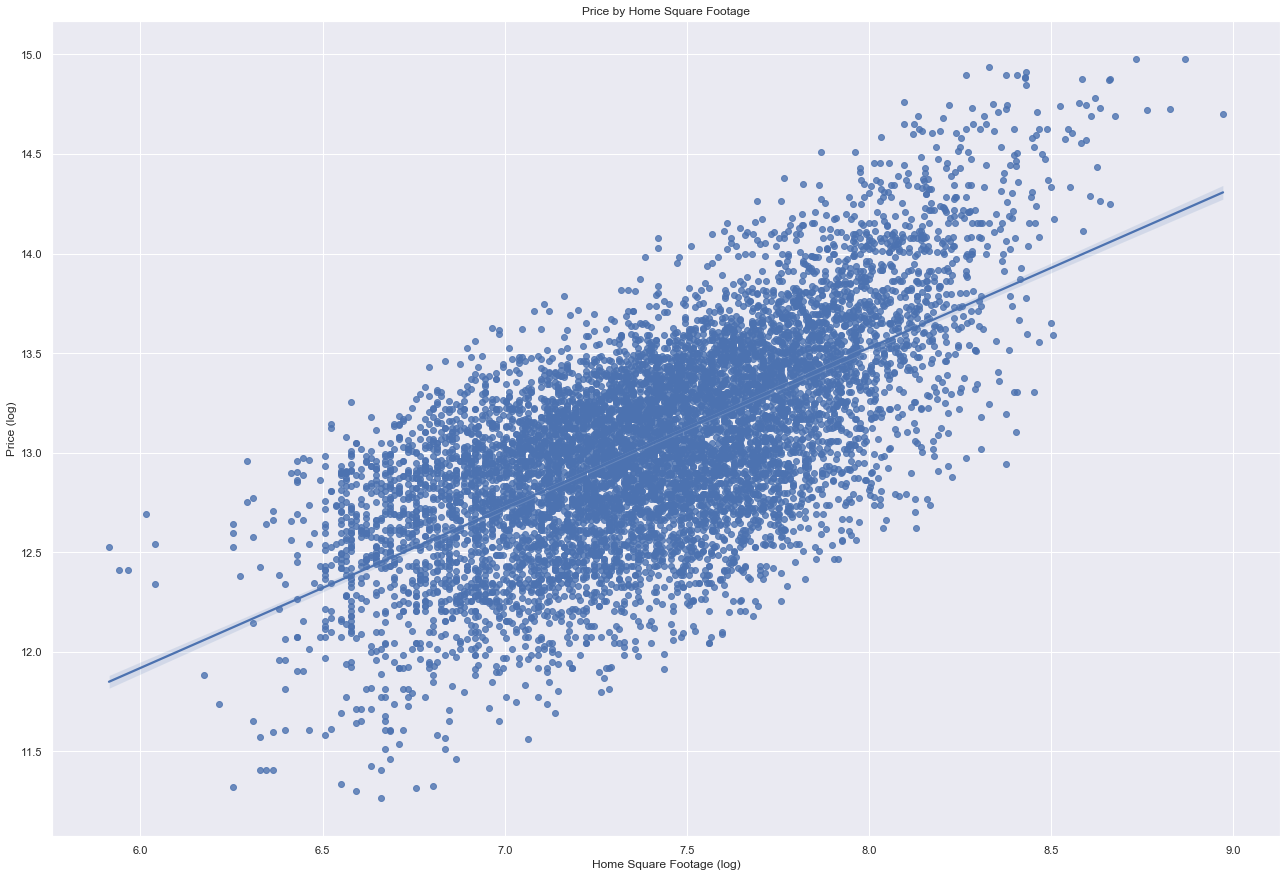

In [181]:
ax = sns.regplot(x="log_sqft_living", y="log_price", data=sixth_model)
plt.xlabel('Home Square Footage (log)')
plt.ylabel('Price (log)')
plt.title('Price by Home Square Footage')

## Final Model Selection

The `sixth_model` may be useful for predicting housing prices in Seattle. Many of the coefficients contain statistically significant $p$ values for predicting price, have moderately high coefficient strengths, and are not highly multicollinear. Additionally, according to the train-test split, the $R^{2}$ values for both training and testing data are nearly equivalent (Training $R^{2}$ = **0.776**; Testing $R^{2}$ = **0.777**). The $R^{2}$ for the cross-validation test for $k$=20 is **0.81**. Based on these results, this model is able to explain at least 77% of the variance for predicting housing prices with low mean absolute error (**0.18**).

## Analysis and Interpretation

This project attempted to delineate the various factors that predict to housing prices in Seattle. The greatest predictor is a home's square footage (coef = 0.28, $p$<0.000) and zip code, namely `98168` (coef = -0.16, $p$<0.00), `98198` (coef = -0.15, $p$<0.00), and `98178` (coef = -0.14, $p$<0.00).

This project attempted to delineate which zip codes could best predict housing prices. The model shows that many of the zip codes are statistically significant predictors for `log_price` ($p$<0.000) for the exception of `98105` ($p$=0.394), `98109` ($p$=0.120) and `98119` ($p$=0.366). Notably, this model predicts home prices to be lower in many zip codes, especially `98168` (coef = -0.16), `98198` (coef = -0.15), and `98178` (coef = -0.14). 

Lastly, while a home on the waterfront (coef = 0.06) has a moderate effect on home price, age nor floor have large effects.

## Recommendations

For individuals seeking more affordable housing options, some recommended zip codes to seek, based on this model, are aforementioned zip codes. Based on the model, one may expect smaller homes of smaller size compared to zip codes that contain higher priced homes. 

## Future Work

While this model has some useful attributes for predicting housing prices in Seattle, it does have limitations. Bins for house age were uneven, which may have negatively impacted the overall normality of the model's data. The zip code categorization could be more broad, such as by council district; this could possibly illumine political implications. Additionally, the model may improve if it incorporates additional features, such as the recency of its renovations and home square footage in relation to its neighbors. Lastly, investigations for the model's generalizability to King County and/or other surrounding areas are warranted, as well.